In [122]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from datetime import date
from sklearn.preprocessing import PowerTransformer
from sklearn.feature_selection import RFE
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor




import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    median = np.nanmedian([np.NaN, np.NaN])

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Step 1: Import the Data

In [2]:
train_df = pd.read_csv('train.csv')
rfe_df = train_df.copy()

# Step 2: Understanding the Data


In [3]:
train_df.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3         Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4         Lvl    AllPub       FR2       Gtl      NoRidge       Norm   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0       Norm     1Fam     2Story            7            5       2003   
1       Norm     1Fam     1Story            6            8       1976   
2       Norm     1Fam     2Story            7            5       2001   
3       Norm     1Fam     2Story            7            5       1915   
4       Norm     1Fam     2Story            8            5       2000   

   YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0          2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   
1          1976     Gable  CompShg     MetalSd     MetalSd       None   
2          2002     Gable  CompShg     VinylSd     VinylSd    BrkFace   
3          1970     Gable  CompShg     Wd Sdng     Wd Shng       None   
4          2000     Gable  CompShg     VinylSd     VinylSd    BrkFace   

   MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
0       196.0        Gd        TA      PConc       Gd       TA           No   
1         0.0        TA        TA     CBlock       Gd       TA           Gd   
2       162.0        Gd        TA      PConc       Gd       TA           Mn   
3         0.0        TA        TA     BrkTil       TA       Gd           No   
4       350.0        Gd        TA      PConc       Gd       TA           Av   

  BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
0          GLQ         706          Unf           0        150          856   
1          ALQ         978          Unf           0        284         1262   
2          GLQ         486          Unf           0        434          920   
3          ALQ         216          Unf           0        540          756   
4          GLQ         655          Unf           0        490         1145   

  Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
0    GasA        Ex          Y      SBrkr       856       854             0   
1    GasA        Ex          Y      SBrkr      1262         0             0   
2    GasA        Ex          Y      SBrkr       920       866             0   
3    GasA        Gd          Y      SBrkr       961       756             0   
4    GasA        Ex          Y      SBrkr      1145      1053             0   

   GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
0       1710             1             0         2         1             3   
1       1262             0             1         2         0             3   
2       1786             1             0         2         1             3   
3       1717             1             0         1         0             3   
4       2198             1             0         2         1             4   

   KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu  \
0             1          Gd             8        Typ           0         NaN   
1             1          TA             6        Typ           1          TA   
2             1          Gd             6        Typ           1          TA   
3             1          Gd            

## Date Columns

These variables will be converted to datatime year

In [4]:
date_columns = ['YrSold','GarageYrBlt','YearBuilt','YearBuilt']

## Set TARGET variable

In [5]:
# Target is the dependent variable that we want to predict
TARGET = 'SalePrice'

In [6]:
train_df.describe()

Id   MSSubClass  LotFrontage        LotArea  OverallQual  \
count  1460.000000  1460.000000  1201.000000    1460.000000  1460.000000   
mean    730.500000    56.897260    70.049958   10516.828082     6.099315   
std     421.610009    42.300571    24.284752    9981.264932     1.382997   
min       1.000000    20.000000    21.000000    1300.000000     1.000000   
25%     365.750000    20.000000    59.000000    7553.500000     5.000000   
50%     730.500000    50.000000    69.000000    9478.500000     6.000000   
75%    1095.250000    70.000000    80.000000   11601.500000     7.000000   
max    1460.000000   190.000000   313.000000  215245.000000    10.000000   

       OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  \
count  1460.000000  1460.000000   1460.000000  1452.000000  1460.000000   
mean      5.575342  1971.267808   1984.865753   103.685262   443.639726   
std       1.112799    30.202904     20.645407   181.066207   456.098091   
min       1.000000  1872.000000   1950.000000     0.000000     0.000000   
25%       5.000000  1954.000000   1967.000000     0.000000     0.000000   
50%       5.000000  1973.000000   1994.000000     0.000000   383.500000   
75%       6.000000  2000.000000   2004.000000   166.000000   712.250000   
max       9.000000  2010.000000   2010.000000  1600.000000  5644.000000   

        BsmtFinSF2    BsmtUnfSF  TotalBsmtSF     1stFlrSF     2ndFlrSF  \
count  1460.000000  1460.000000  1460.000000  1460.000000  1460.000000   
mean     46.549315   567.240411  1057.429452  1162.626712   346.992466   
std     161.319273   441.866955   438.705324   386.587738   436.528436   
min       0.000000     0.000000     0.000000   334.000000     0.000000   
25%       0.000000   223.000000   795.750000   882.000000     0.000000   
50%       0.000000   477.500000   991.500000  1087.000000     0.000000   
75%       0.000000   808.000000  1298.250000  1391.250000   728.000000   
max    1474.000000  2336.000000  6110.000000  4692.000000  2065.000000   

       LowQualFinSF    GrLivArea  BsmtFullBath  BsmtHalfBath     FullBath  \
count   1460.000000  1460.000000   1460.000000   1460.000000  1460.000000   
mean       5.844521  1515.463699      0.425342      0.057534     1.565068   
std       48.623081   525.480383      0.518911      0.238753     0.550916   
min        0.000000   334.000000      0.000000      0.000000     0.000000   
25%        0.000000  1129.500000      0.000000      0.000000     1.000000   
50%        0.000000  1464.000000      0.000000      0.000000     2.000000   
75%        0.000000  1776.750000      1.000000      0.000000     2.000000   
max      572.000000  5642.000000      3.000000      2.000000     3.000000   

          HalfBath  BedroomAbvGr  KitchenAbvGr  TotRmsAbvGrd   Fireplaces  \
count  1460.000000   1460.000000   1460.000000   1460.000000  1460.000000   
mean      0.382877      2.866438      1.046575      6.517808     0.613014   
std       0.502885      0.815778      0.220338      1.625393     0.644666   
min       0.000000      0.000000      0.000000      2.000000     0.000000   
25%       0.000000      2.000000      1.000000      5.000000     0.000000   
50%       0.000000      3.000000      1.000000      6.000000     1.000000   
75%       1.000000      3.000000      1.000000      7.000000     1.000000   
max       2.000000      8.000000      3.000000     14.000000     3.000000   

       GarageYrBlt   GarageCars   GarageArea   WoodDeckSF  OpenPorchSF  \
count  1379.000000  1460.000000  1460.000000  1460.000000  1460.000000   
mean   1978.506164     1.767123   472.980137    94.244521    46.660274   
std      24.689725     0.747315   213.804841   125.338794    66.256028   
min    1900.000000     0.000000     0.000000     0.000000     0.000000   
25%    1961.000000     1.000000   334.500000     0.000000     0.000000   
50%    1980.000000     2.000000   480.000000     0.000000    25.000000   
75%    2002.000000     2.000000   576.000000   168.000000    68.000000   
max    2

## Handling Missing Values

Let's address the 19 variables with missing values.  Scatterplot the missing variables to learn the 
characteristic and the spread of the data.  This will help us determine which method to use.


- LotFrontage - mean/median/mode
- GarageYrBlt- mean/median/mode
- MasVnrArea - mean/median/mode
- MasVnrType - None
- Electrical - Mixed
- The remainder should fillna('NA')

In [7]:
empty_cols = [col for col in train_df if train_df[col].isnull().sum()>0]
missing_pct = (train_df[empty_cols].isnull().sum()/train_df[empty_cols].isnull().count()).sort_values(ascending=False)

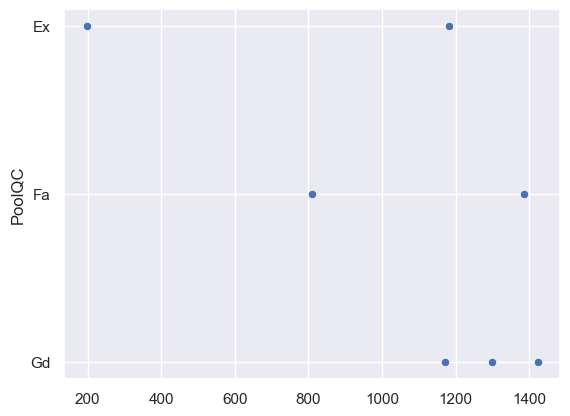

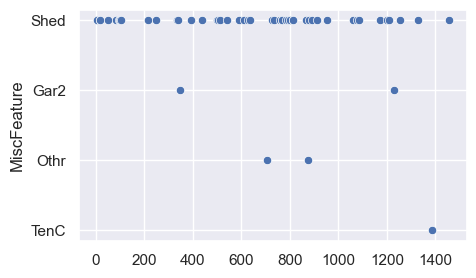

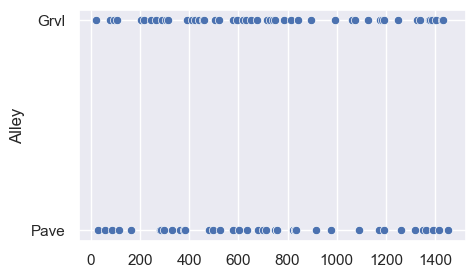

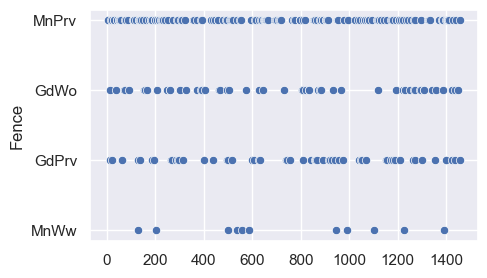

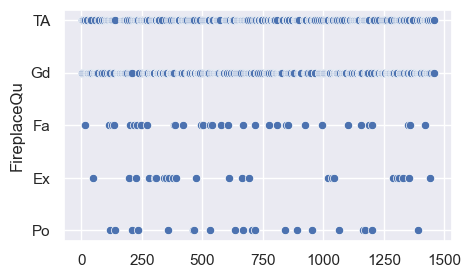

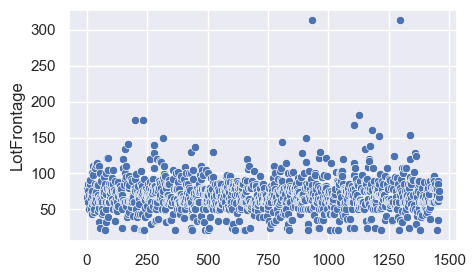

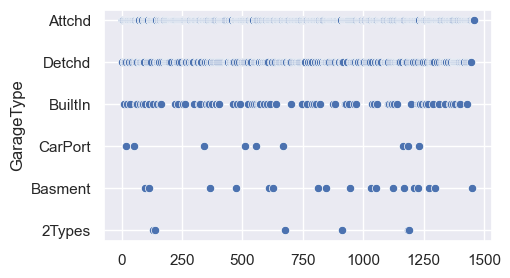

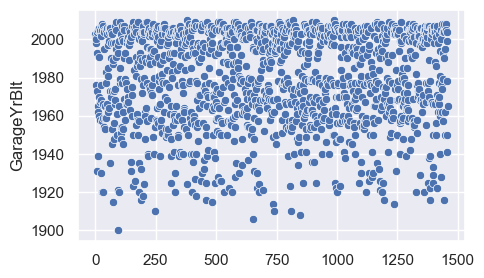

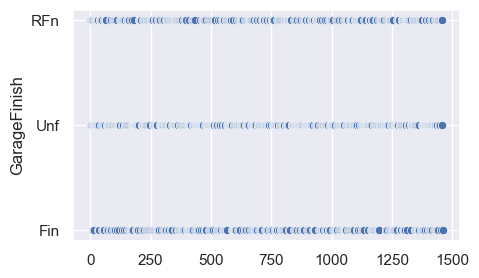

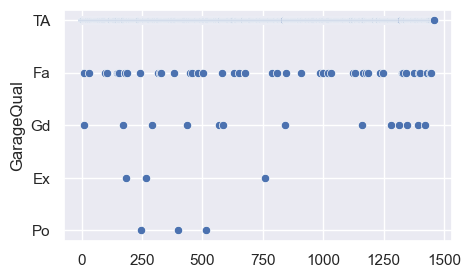

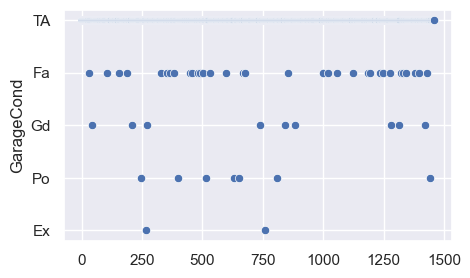

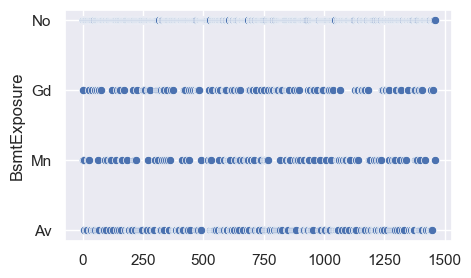

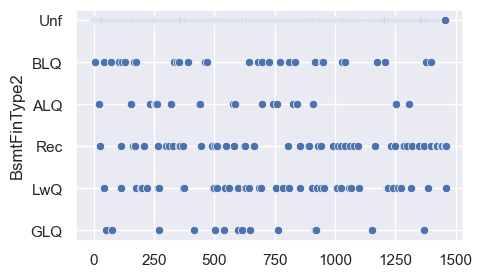

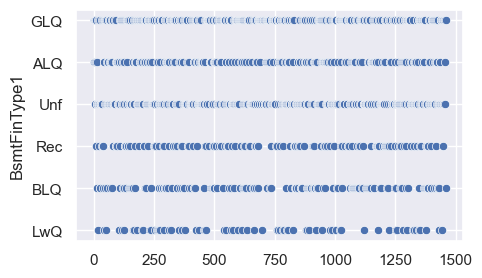

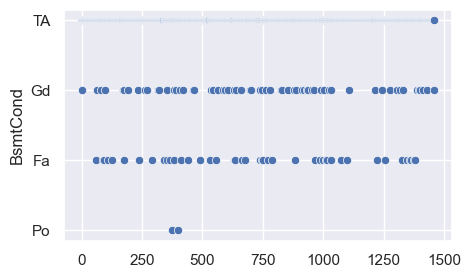

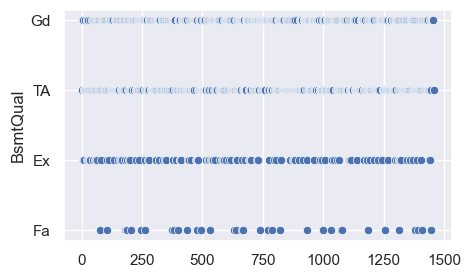

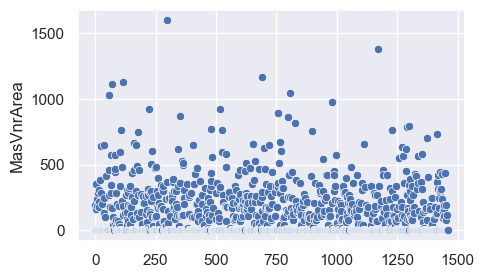

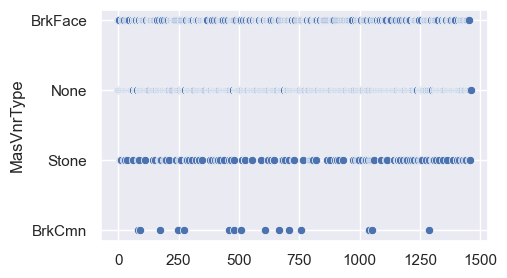

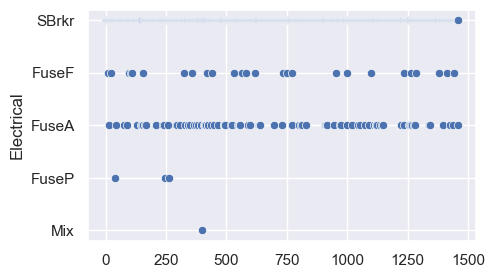

In [8]:
for i in missing_pct.index:
    plt.figure()
    plt.tight_layout()
    sns.set(rc={"figure.figsize":(5, 3)})
    sns.scatterplot(train_df[i])

LotFrontage and MasVnrArea have large outlier.  In order to minimize impact, we use median.  We fillna with mean for GarageYrBlt as it does not have wide range. Use None to fillna for MasVnrType. Use Mixed to fillna for Electrical.  For the remaining NaN, we use NA.

In [9]:
# BsmtQual - NA
# BsmtCond - NA
# BsmtExposure - NA
# BsmtFinType1 - NA
# BsmtFinType1 - NA
# FireplaceQu - NA
# GarageType - NA
# GarageFinish - NA
# GarageQual - NA
# GarageCond - NA
# PoolQC - NA
# Fence - NA
# MiscFeature - NA

## Convert date string to datetime

We can do datetime calculation later on such as finding the HouseAge.

In [10]:
for date in date_columns:
    train_df[date] = pd.to_datetime(train_df[date], format='%Y')
    train_df[date] = train_df[date].dt.year

## Feature Engineering

Since we have four dates (YearRemodAdd, YrSold, GarageYrBlt, YearBuilt) and some are repetitive.  Let's find the HouseAge and drop YearBuilt.

In [11]:
current_year = dt.date.today().year
train_df['HouseAge'] = current_year - train_df['YearBuilt']
train_df.drop('YearBuilt', axis=1, inplace=True)

In [12]:
train_df['LotFrontage'] = train_df['LotFrontage'].replace(np.NaN, train_df['LotFrontage'].median())
train_df['MasVnrArea'] = train_df['MasVnrArea'].replace(np.NaN, train_df['MasVnrArea'].median())
train_df['GarageYrBlt'].fillna("1971", inplace=True)
train_df['MasVnrType'].fillna("None", inplace=True)
train_df['Electrical'].fillna("Mix", inplace=True)

## Fill remaining NaN with NA

In [13]:
# Change the remaining NaN to NA. This will eliminate all missing values.
empty_cols = [col for col in train_df if train_df[col].isnull().sum()>0]

for c in empty_cols:
#     train_df[c].replace(np.NaN, 'NA', inplace=True)
    train_df[c]=train_df[c].fillna('NA')

In [14]:
missing_values = [col for col in train_df if train_df[col].isnull().sum()>0]

In [15]:
print(f"There are {len(missing_values)} missing values.")

There are 0 missing values.


## Create dictionaries for large categorical variables

MSSubClass, OverallQual, and  OverallCond are actually category but labelled as integer.  It must be converted back to category with diction.  Otherwise when run through dummy variables they will be too many new columns. This will cause slow convergence of the model.

In [16]:
MSSubClass_dict = {
        20:"1-STORY 1946 & NEWER ALL STYLES",
        30:"1-STORY 1945 & OLDER",
        40:"1-STORY W/FINISHED ATTIC ALL AGES",
        45:"1-1/2 STORY - UNFINISHED ALL AGES",
        50:"1-1/2 STORY FINISHED ALL AGES",
        60:"2-STORY 1946 & NEWER",
        70:"2-STORY 1945 & OLDER",
        75:"2-1/2 STORY ALL AGES",
        80:"SPLIT OR MULTI-LEVEL",
        85:"SPLIT FOYER",
        90:"DUPLEX - ALL STYLES AND AGES",
       120:"1-STORY PUD (Planned Unit Development) - 1946 & NEWER",
       150:"1-1/2 STORY PUD - ALL AGES",
       160:"2-STORY PUD - 1946 & NEWER",
       180:"PUD - MULTILEVEL - INCL SPLIT LEV/FOYER",
       190:"2 FAMILY CONVERSION - ALL STYLES AND AGES"
}

train_df.MSSubClass = train_df.MSSubClass.apply(lambda x: MSSubClass_dict[x])
train_df.MSSubClass.head() 

0               2-STORY 1946 & NEWER
1    1-STORY 1946 & NEWER ALL STYLES
2               2-STORY 1946 & NEWER
3               2-STORY 1945 & OLDER
4               2-STORY 1946 & NEWER
Name: MSSubClass, dtype: object

In [17]:
OverallQual_dict = {
        10:"Very Excellent",
        9:"Excellent",
        8:"Very Good",
        7:"Good",
        6:"Above Average",
        5:"Average",
        4:"Below Average",
        3:"Fair",
        2:"Poor",
        1:"Very Poor"
}
train_df.OverallQual = train_df.OverallQual.apply(lambda x: OverallQual_dict[x])
train_df.OverallQual.head() 

0             Good
1    Above Average
2             Good
3             Good
4        Very Good
Name: OverallQual, dtype: object

In [18]:
OverallCond_dict = {
        10:"Very Excellent",
        9:"Excellent",
        8:"Very Good",
        7:"Good",
        6:"Above Average",
        5:"Average",
        4:"Below Average",
        3:"Fair",
        2:"Poor",
        1:"Very Poor"
}
train_df.OverallCond = train_df.OverallCond.apply(lambda x: OverallCond_dict[x])
train_df.OverallCond.head() 

0      Average
1    Very Good
2      Average
3      Average
4      Average
Name: OverallCond, dtype: object

In [19]:
cat_columns = list(train_df.select_dtypes(include = "object").columns)
num_columns = list(train_df.select_dtypes(exclude = "object").columns)

In [20]:
train_df[num_columns].nunique()

Id               1460
LotFrontage       110
LotArea          1073
YearRemodAdd       61
MasVnrArea        327
BsmtFinSF1        637
BsmtFinSF2        144
BsmtUnfSF         780
TotalBsmtSF       721
1stFlrSF          753
2ndFlrSF          417
LowQualFinSF       24
GrLivArea         861
BsmtFullBath        4
BsmtHalfBath        3
FullBath            4
HalfBath            3
BedroomAbvGr        8
KitchenAbvGr        4
TotRmsAbvGrd       12
Fireplaces          4
GarageCars          5
GarageArea        441
WoodDeckSF        274
OpenPorchSF       202
EnclosedPorch     120
3SsnPorch          20
ScreenPorch        76
PoolArea            8
MiscVal            21
MoSold             12
YrSold              5
SalePrice         663
HouseAge          112
dtype: int64

In [21]:
train_df[num_columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 34 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   LotFrontage    1460 non-null   float64
 2   LotArea        1460 non-null   int64  
 3   YearRemodAdd   1460 non-null   int64  
 4   MasVnrArea     1460 non-null   float64
 5   BsmtFinSF1     1460 non-null   int64  
 6   BsmtFinSF2     1460 non-null   int64  
 7   BsmtUnfSF      1460 non-null   int64  
 8   TotalBsmtSF    1460 non-null   int64  
 9   1stFlrSF       1460 non-null   int64  
 10  2ndFlrSF       1460 non-null   int64  
 11  LowQualFinSF   1460 non-null   int64  
 12  GrLivArea      1460 non-null   int64  
 13  BsmtFullBath   1460 non-null   int64  
 14  BsmtHalfBath   1460 non-null   int64  
 15  FullBath       1460 non-null   int64  
 16  HalfBath       1460 non-null   int64  
 17  BedroomAbvGr   1460 non-null   int64  
 18  KitchenA

In [22]:
train_df[cat_columns].nunique()

MSSubClass       15
MSZoning          5
Street            2
Alley             3
LotShape          4
LandContour       4
Utilities         2
LotConfig         5
LandSlope         3
Neighborhood     25
Condition1        9
Condition2        8
BldgType          5
HouseStyle        8
OverallQual      10
OverallCond       9
RoofStyle         6
RoofMatl          8
Exterior1st      15
Exterior2nd      16
MasVnrType        4
ExterQual         4
ExterCond         5
Foundation        6
BsmtQual          5
BsmtCond          5
BsmtExposure      5
BsmtFinType1      7
BsmtFinType2      7
Heating           6
HeatingQC         5
CentralAir        2
Electrical        5
KitchenQual       4
Functional        7
FireplaceQu       6
GarageType        7
GarageYrBlt      98
GarageFinish      4
GarageQual        6
GarageCond        6
PavedDrive        3
PoolQC            4
Fence             5
MiscFeature       5
SaleType          9
SaleCondition     6
dtype: int64

In [23]:
train_df[cat_columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 47 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MSSubClass     1460 non-null   object
 1   MSZoning       1460 non-null   object
 2   Street         1460 non-null   object
 3   Alley          1460 non-null   object
 4   LotShape       1460 non-null   object
 5   LandContour    1460 non-null   object
 6   Utilities      1460 non-null   object
 7   LotConfig      1460 non-null   object
 8   LandSlope      1460 non-null   object
 9   Neighborhood   1460 non-null   object
 10  Condition1     1460 non-null   object
 11  Condition2     1460 non-null   object
 12  BldgType       1460 non-null   object
 13  HouseStyle     1460 non-null   object
 14  OverallQual    1460 non-null   object
 15  OverallCond    1460 non-null   object
 16  RoofStyle      1460 non-null   object
 17  RoofMatl       1460 non-null   object
 18  Exterior1st    1460 non-null

# Step 3: Cleaning the Data

Finding missing values and their percentages

In [24]:
print(f'There are {len(missing_pct)} missing data.')

There are 19 missing data.


In [25]:
print("Missing percentages:\n", missing_pct)

Missing percentages:
 PoolQC          0.995205
MiscFeature     0.963014
Alley           0.937671
Fence           0.807534
FireplaceQu     0.472603
LotFrontage     0.177397
GarageType      0.055479
GarageYrBlt     0.055479
GarageFinish    0.055479
GarageQual      0.055479
GarageCond      0.055479
BsmtExposure    0.026027
BsmtFinType2    0.026027
BsmtFinType1    0.025342
BsmtCond        0.025342
BsmtQual        0.025342
MasVnrArea      0.005479
MasVnrType      0.005479
Electrical      0.000685
dtype: float64


## Handle binaries

In [26]:
BINARIES = [col for col in train_df if train_df.nunique()[col]<=2]
train_df['Street']= train_df.Street.map(lambda x: 1 if x=='Pave' else 0)
train_df['Utilities']= train_df.Utilities.map(lambda x: 1 if x=='AllPub' else 0)
train_df['CentralAir']= train_df.CentralAir.map(lambda x: 1 if x=='Y' else 0)

# Step 4: Data Visualization

Use histogram to check the distribution

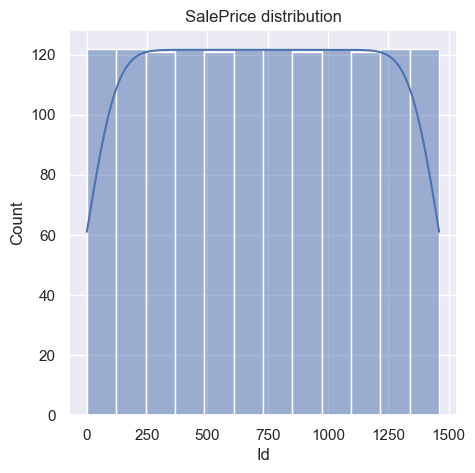

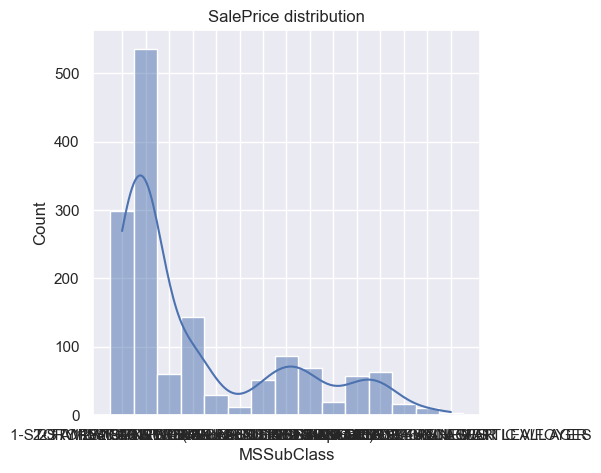

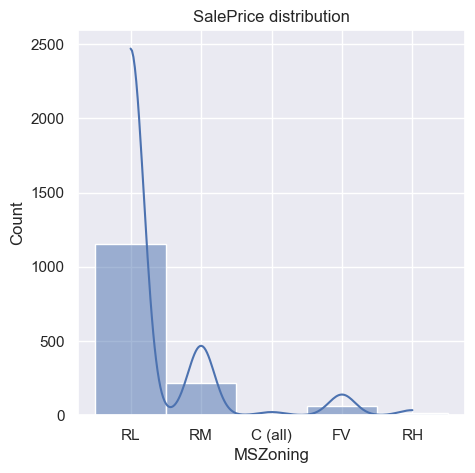

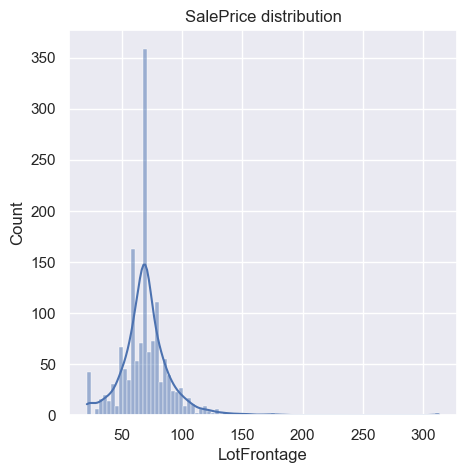

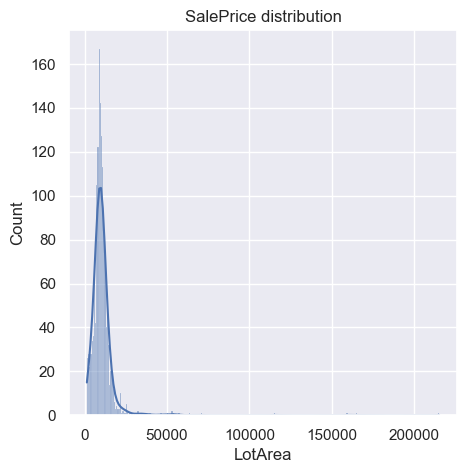

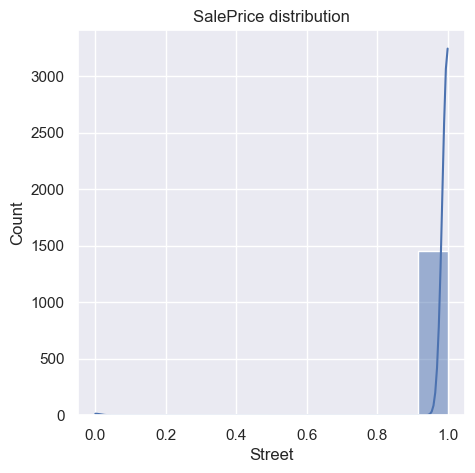

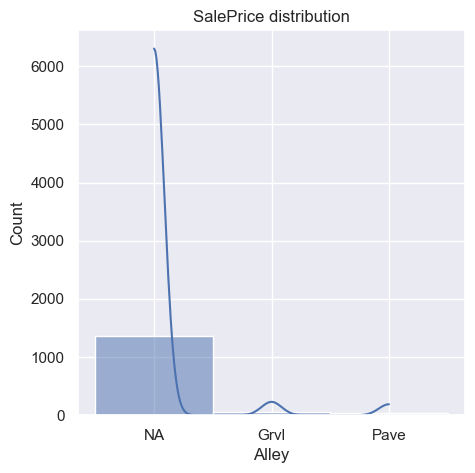

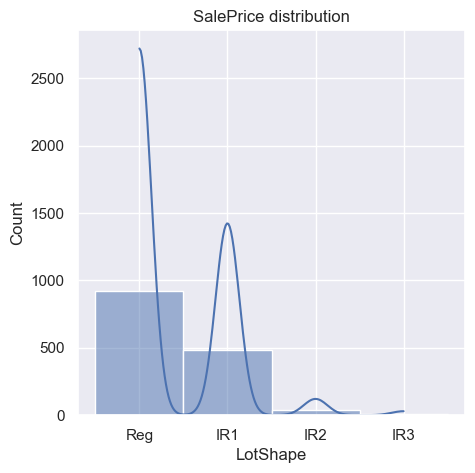

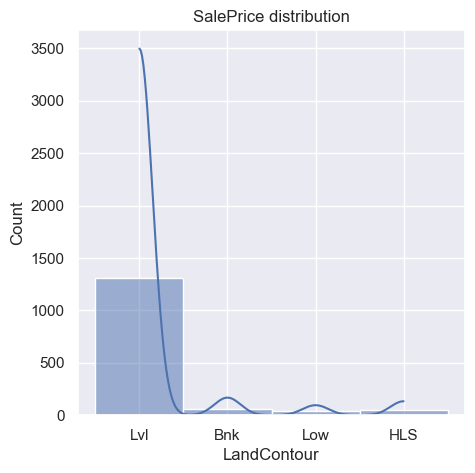

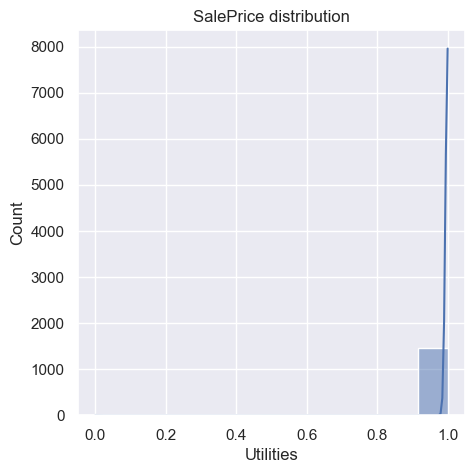

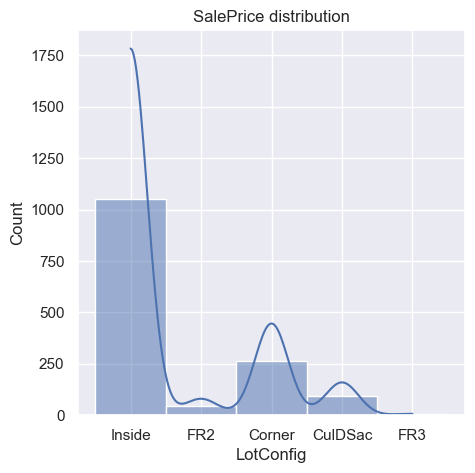

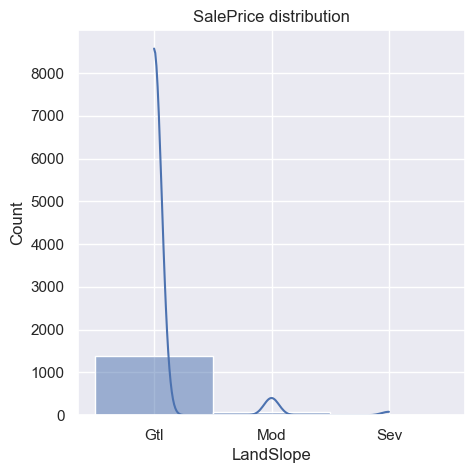

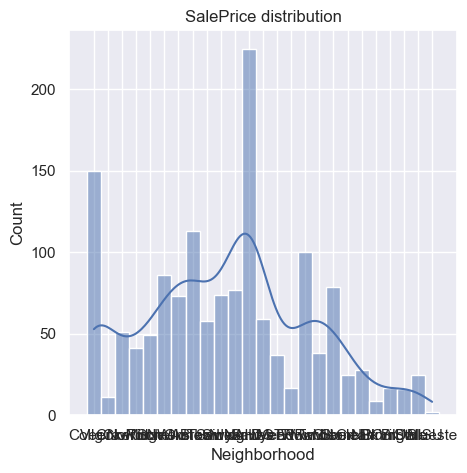

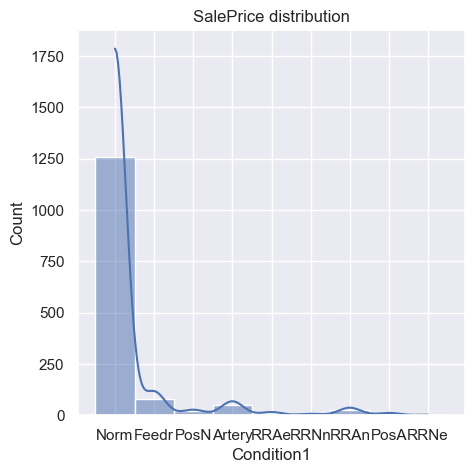

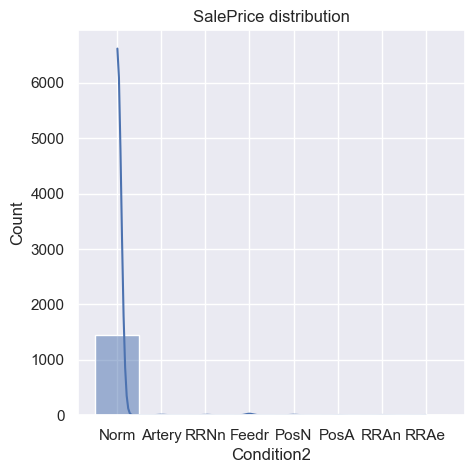

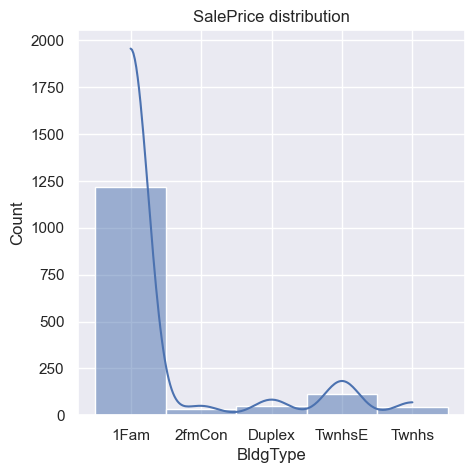

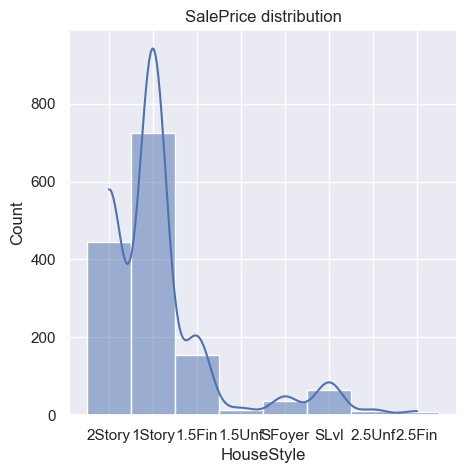

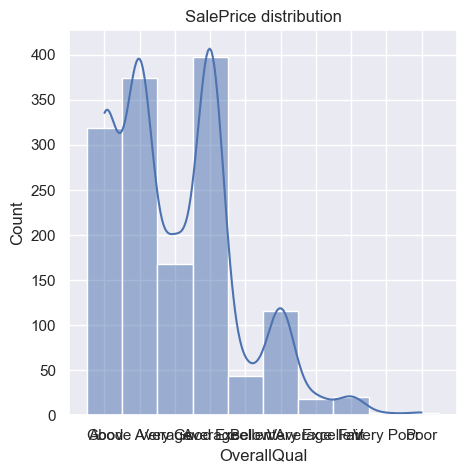

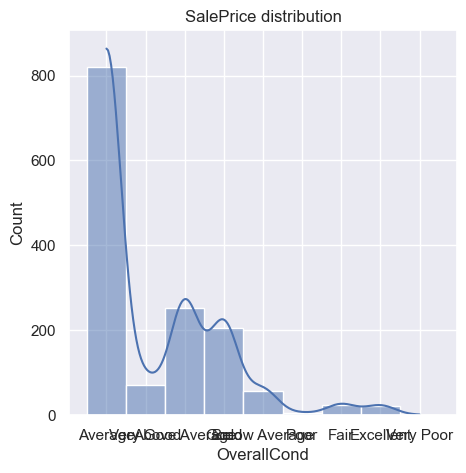

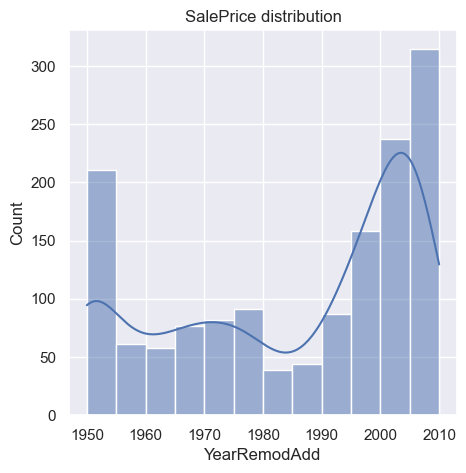

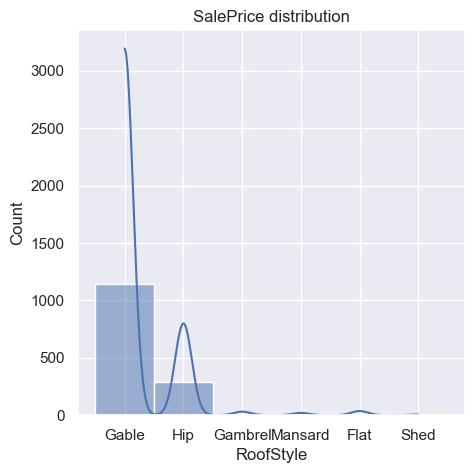

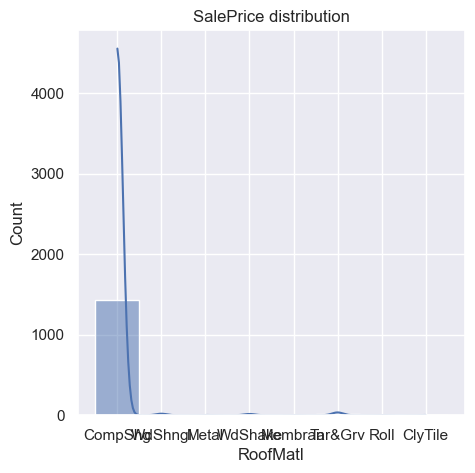

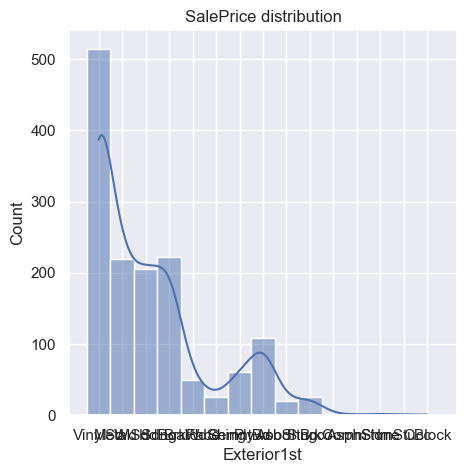

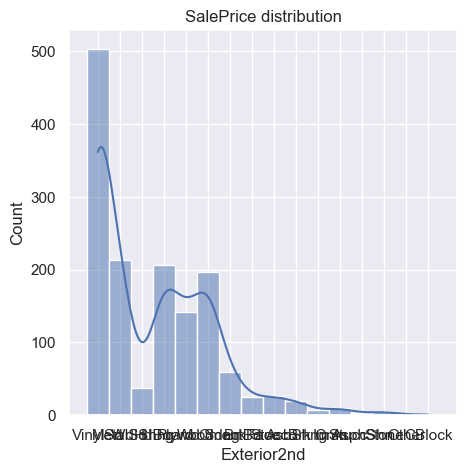

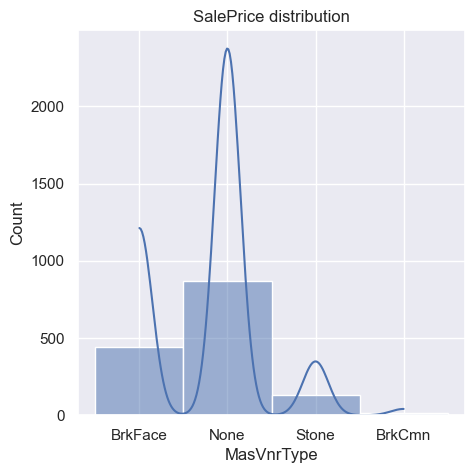

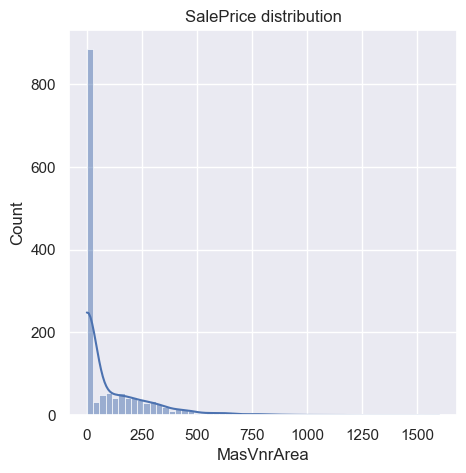

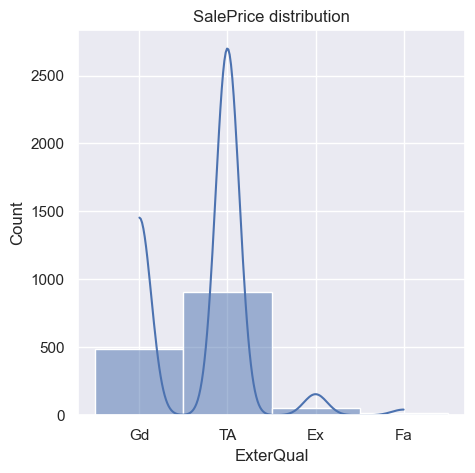

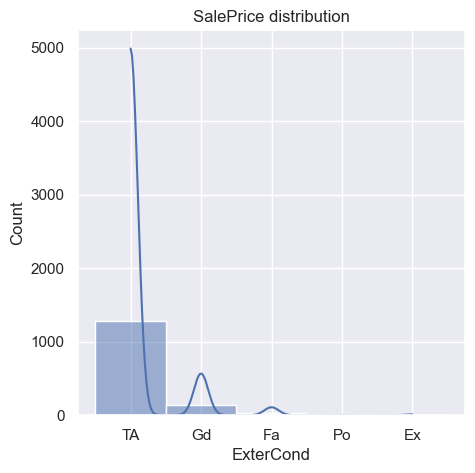

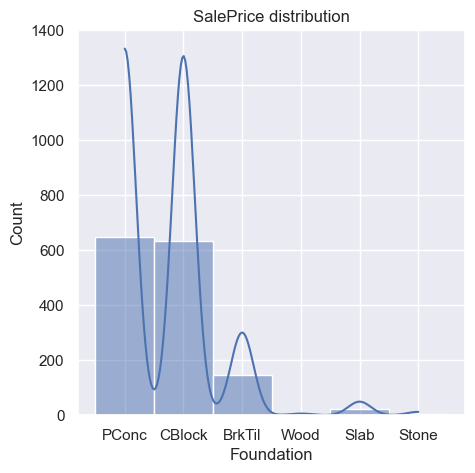

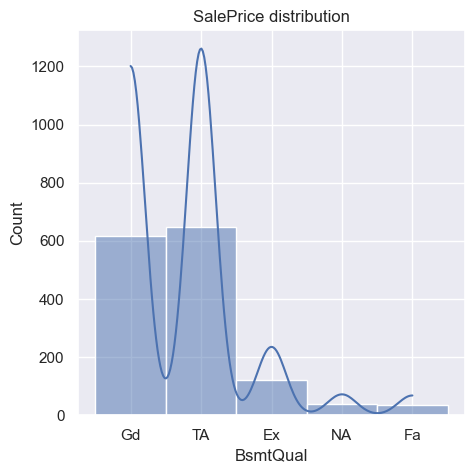

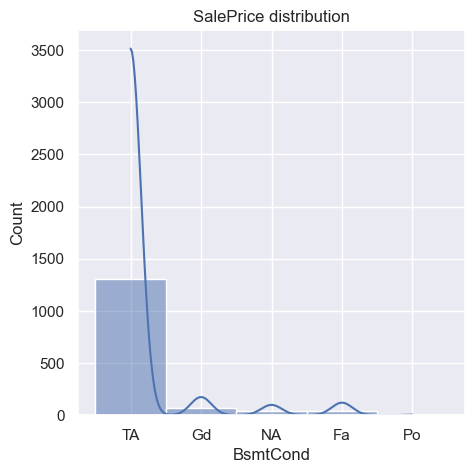

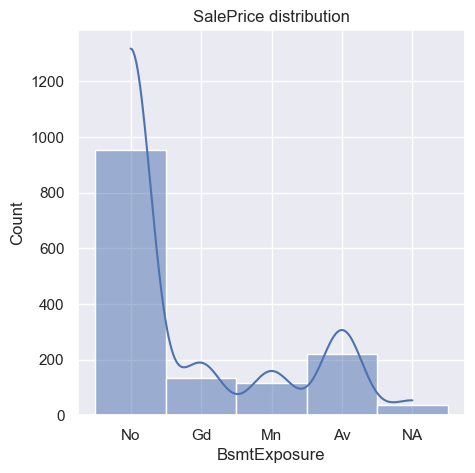

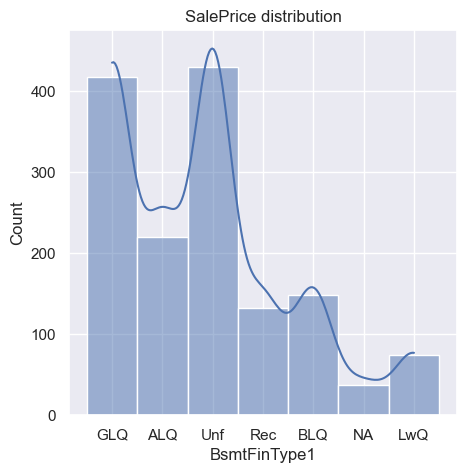

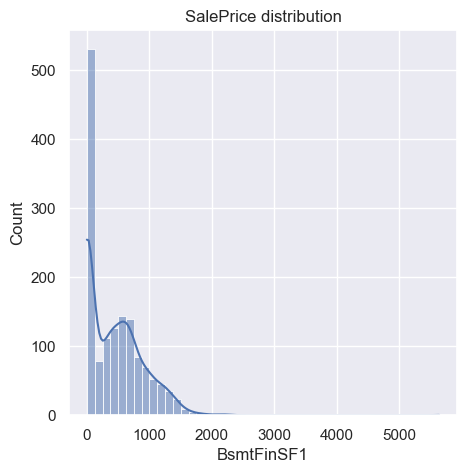

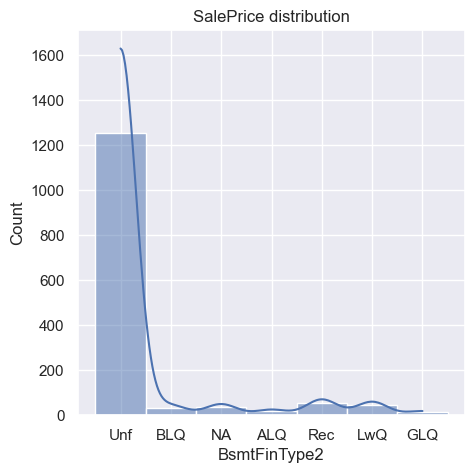

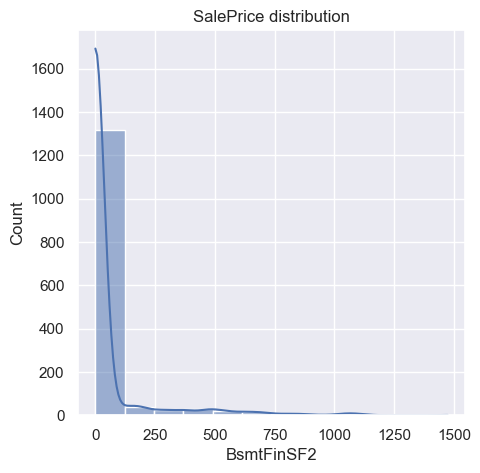

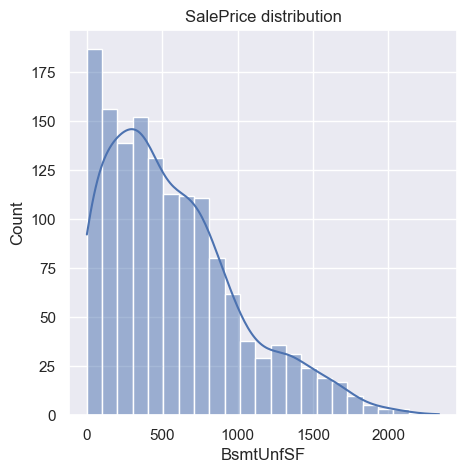

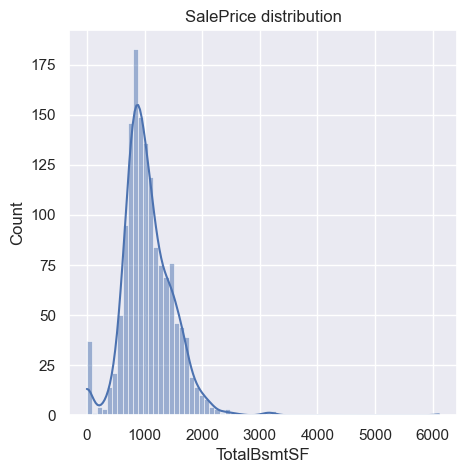

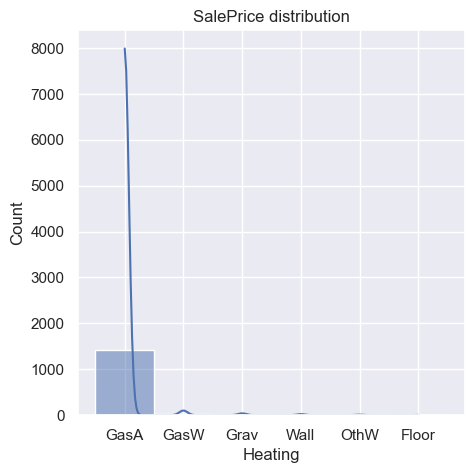

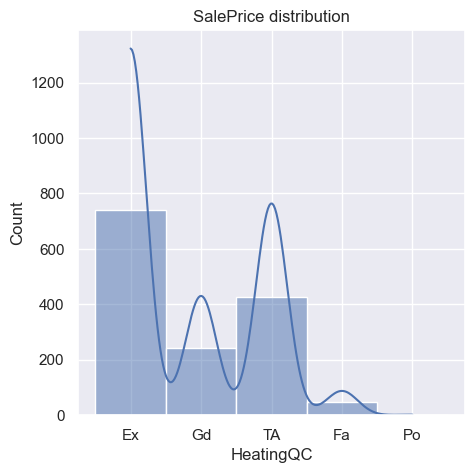

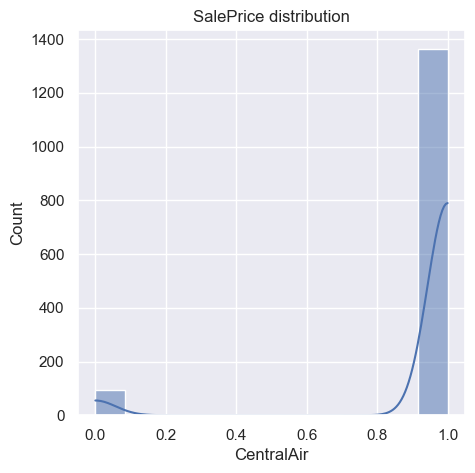

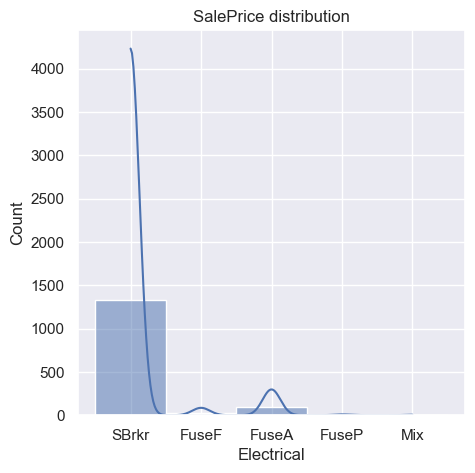

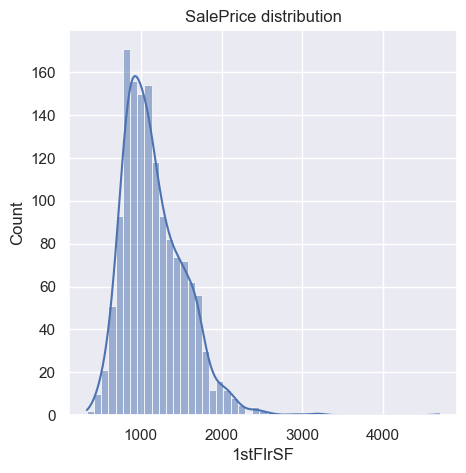

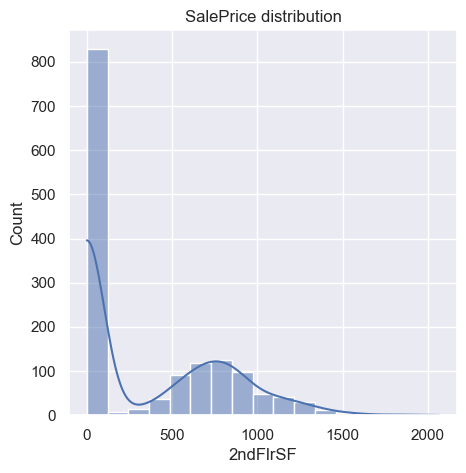

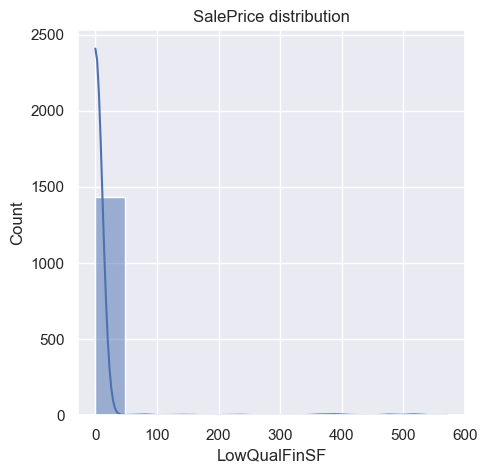

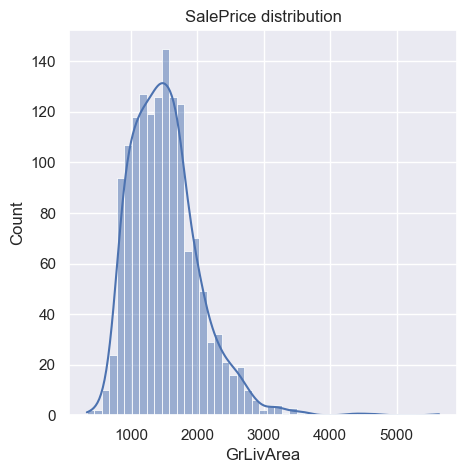

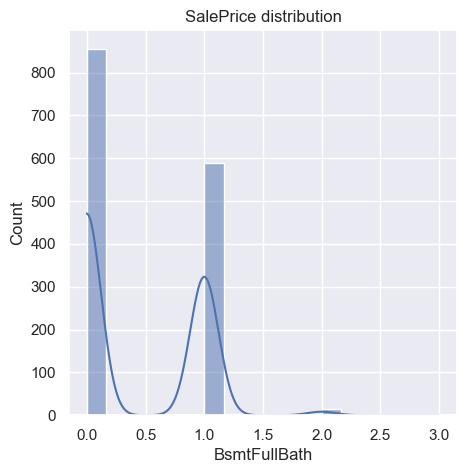

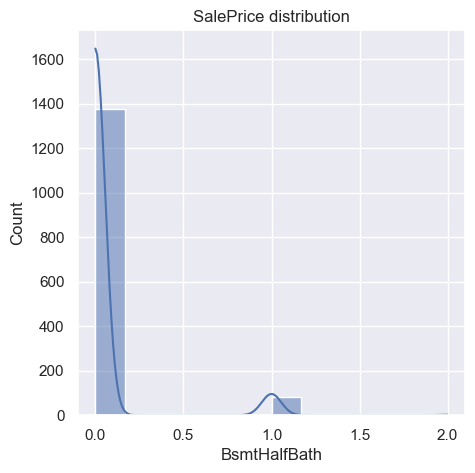

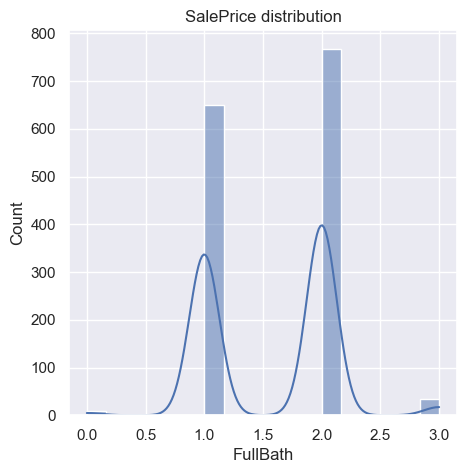

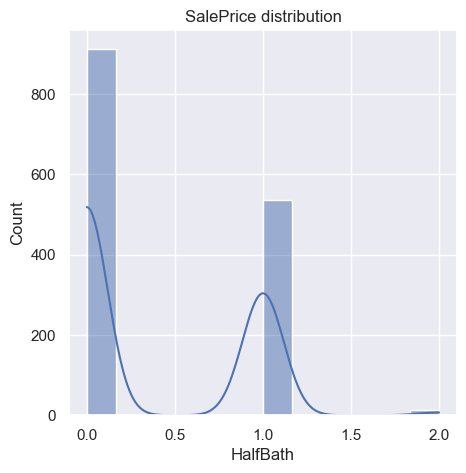

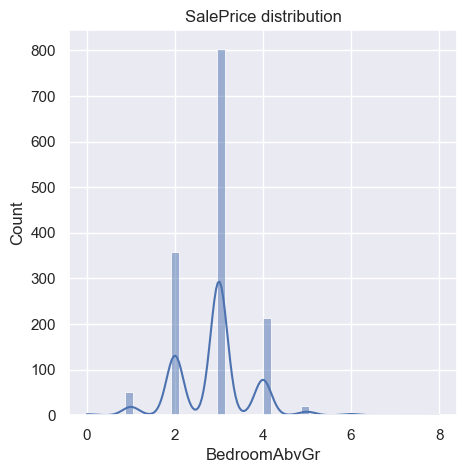

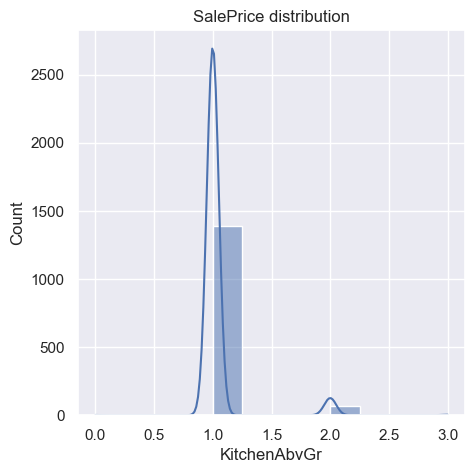

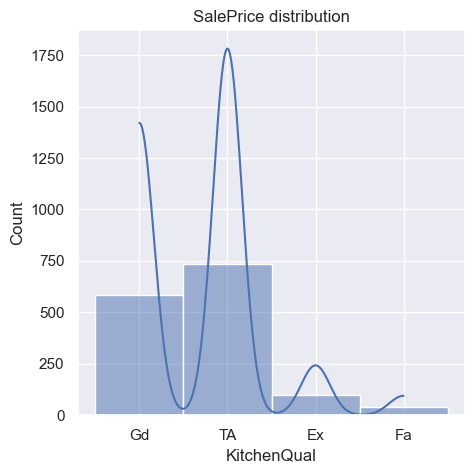

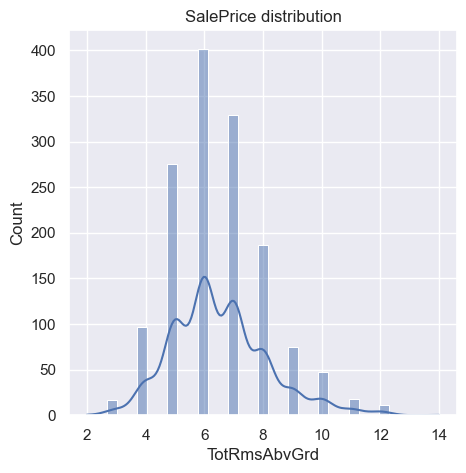

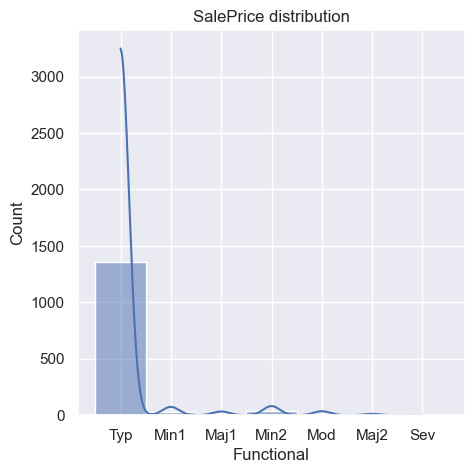

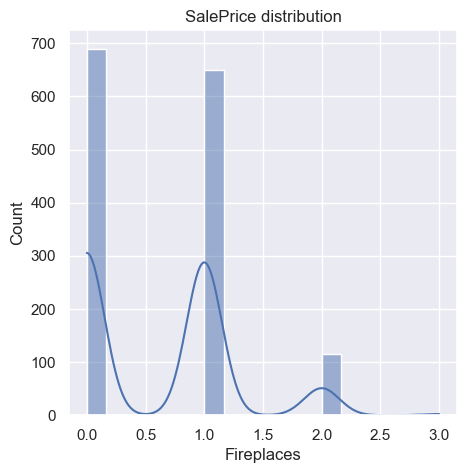

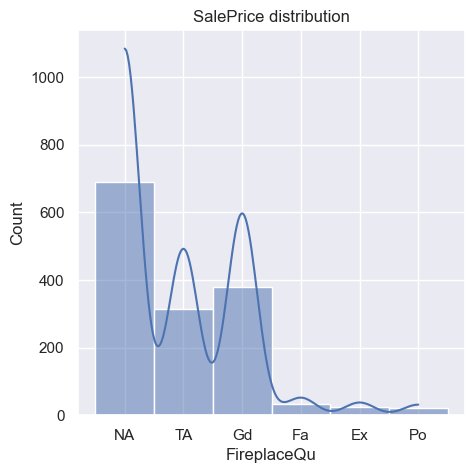

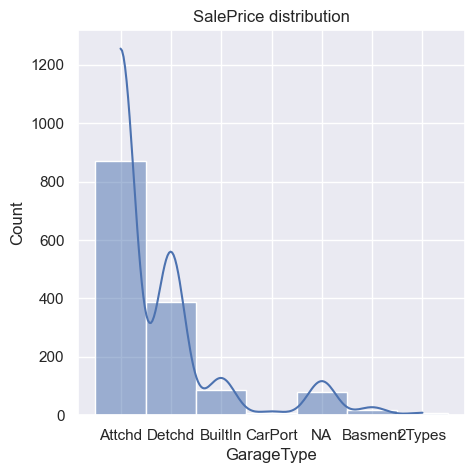

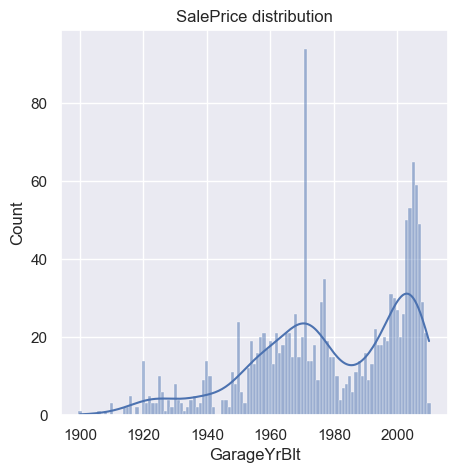

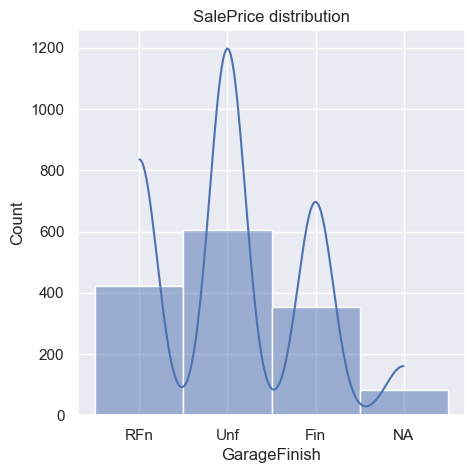

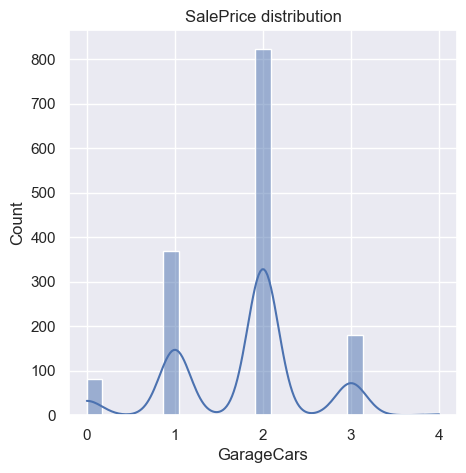

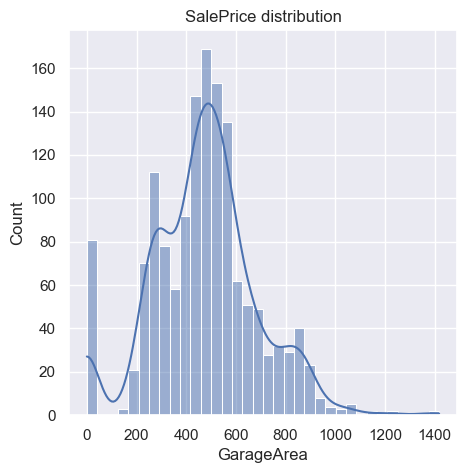

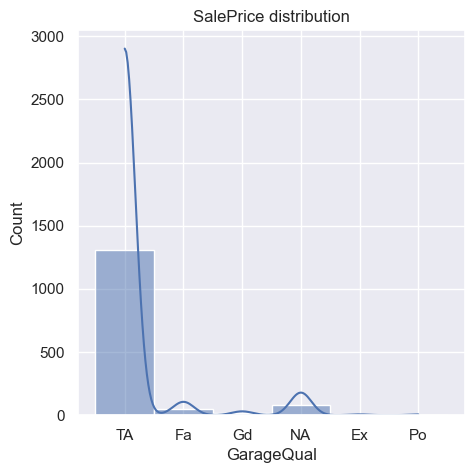

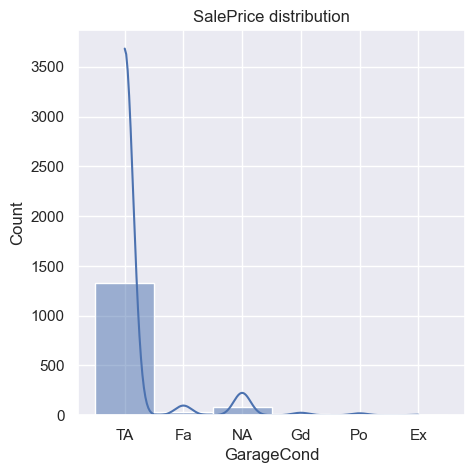

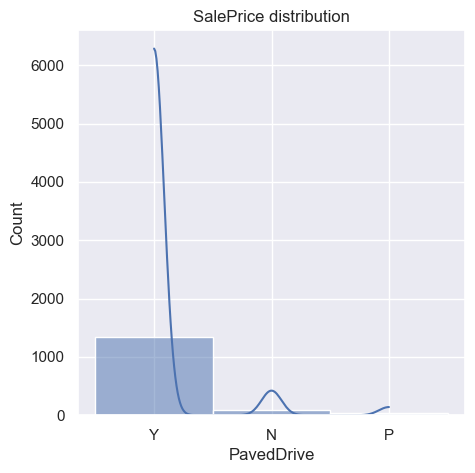

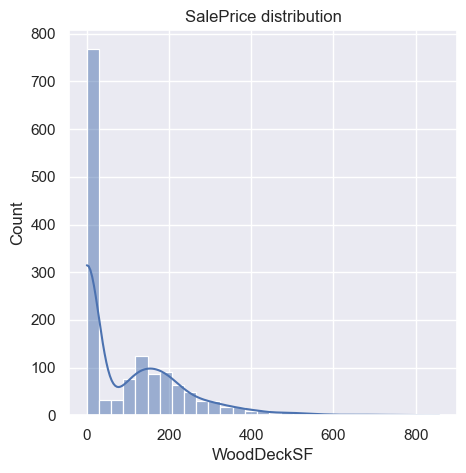

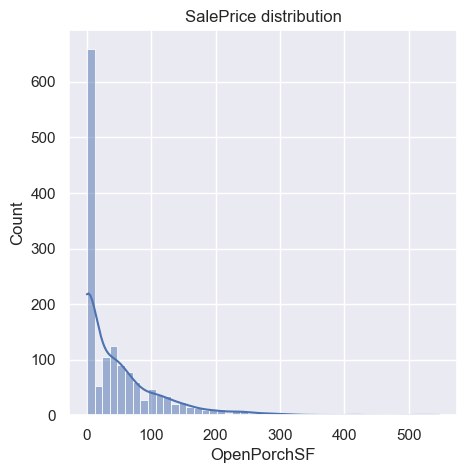

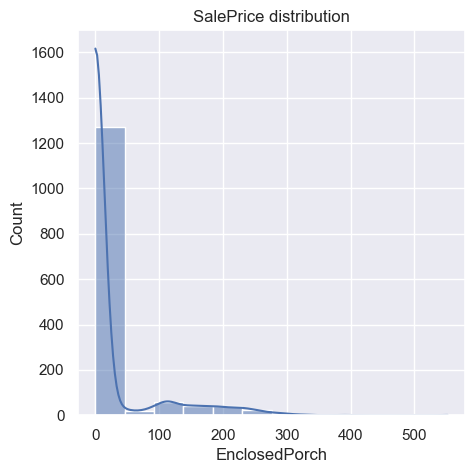

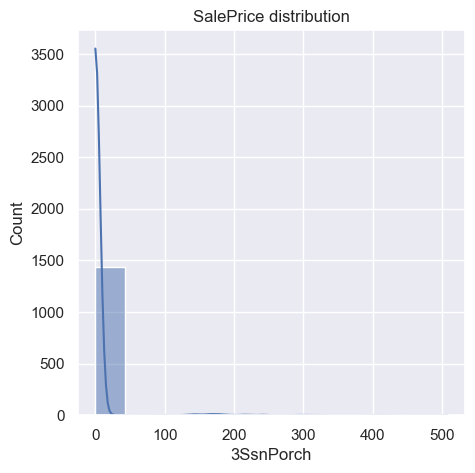

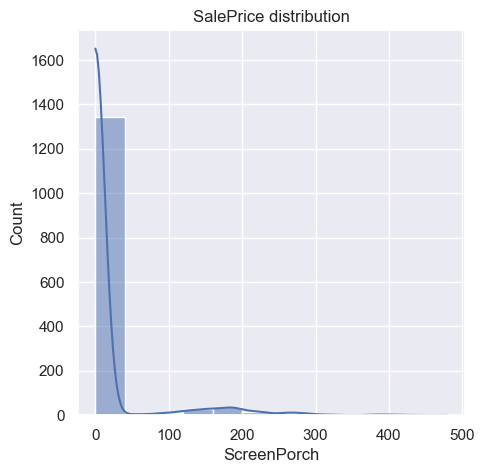

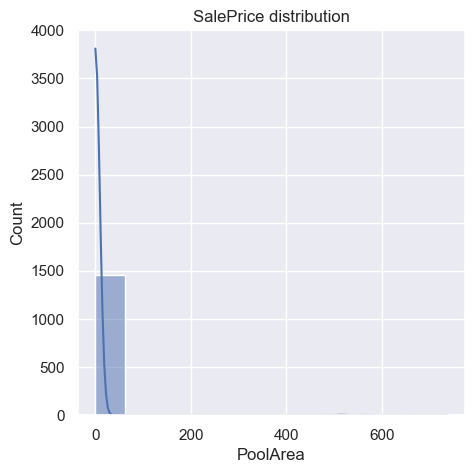

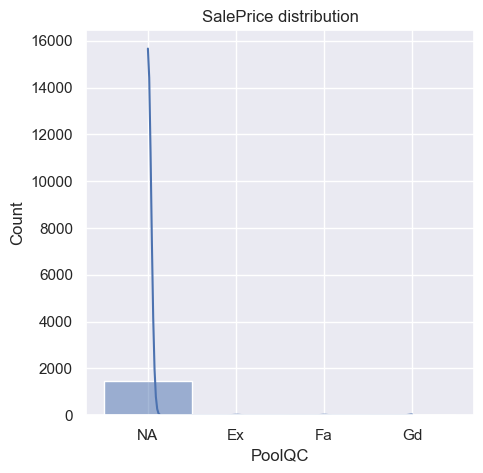

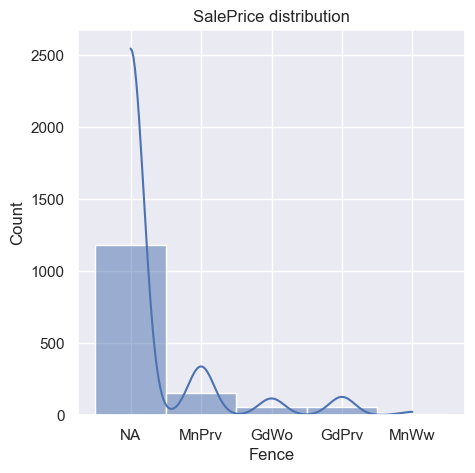

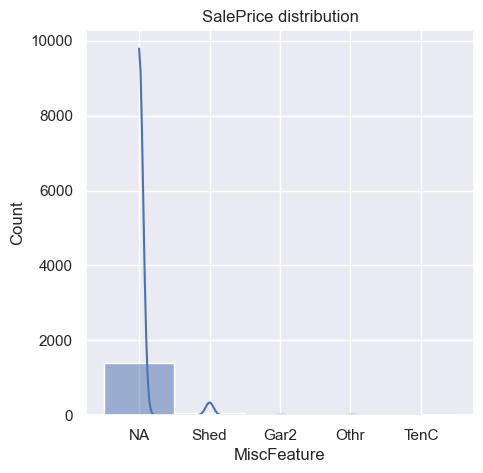

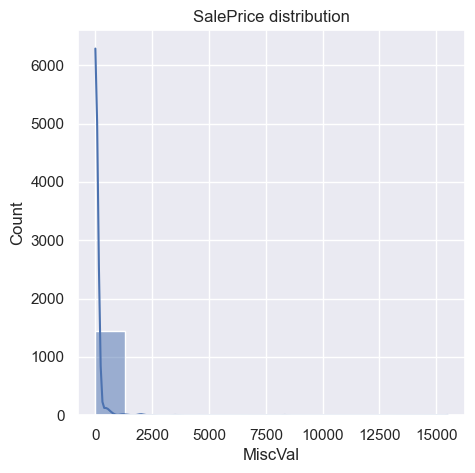

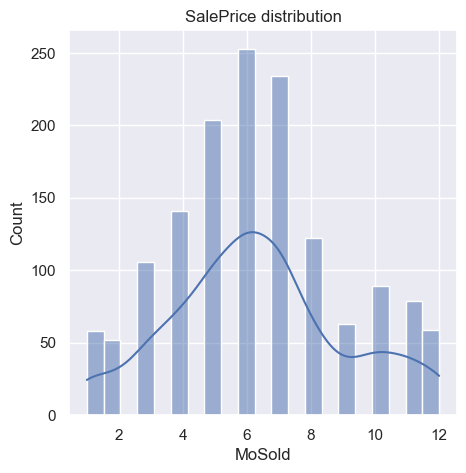

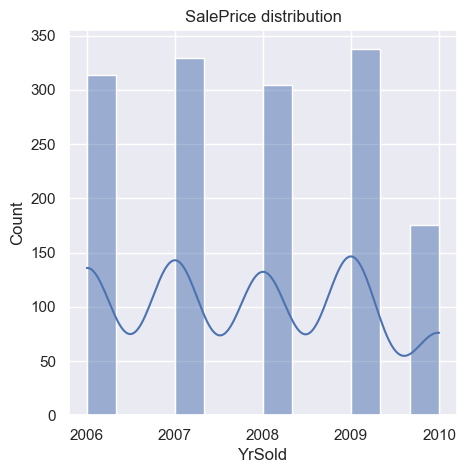

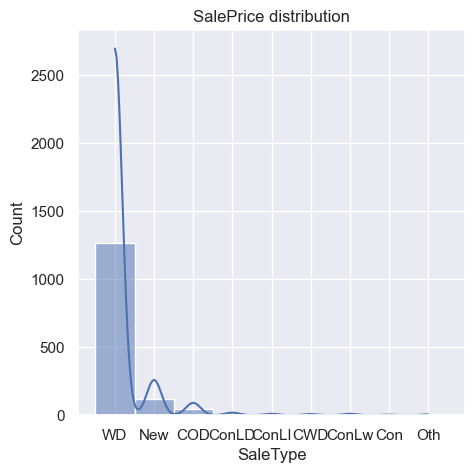

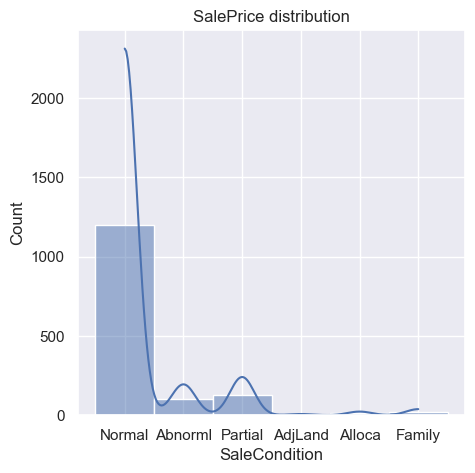

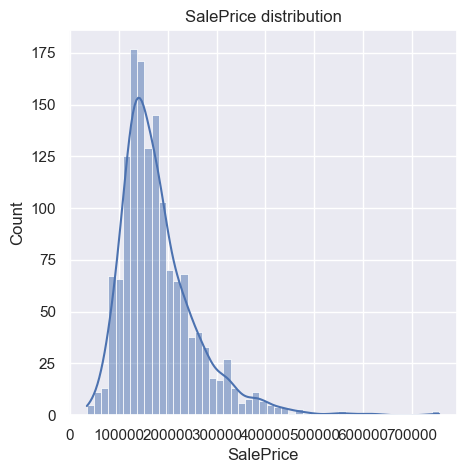

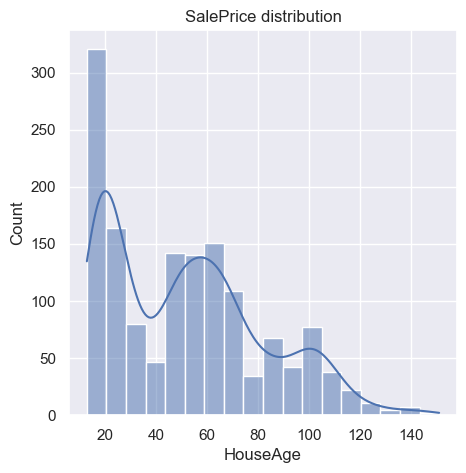

In [27]:
for col in train_df.columns:
    plt.figure(figsize=(5,5))
    plt.title("SalePrice distribution")
    sns.histplot(train_df[col], kde=True)
    plt.show()


## Analysis based on boxplot:
- Every variable has outlier.  Some are more than others.  We'll drop the outliers +-2 standard deviation.

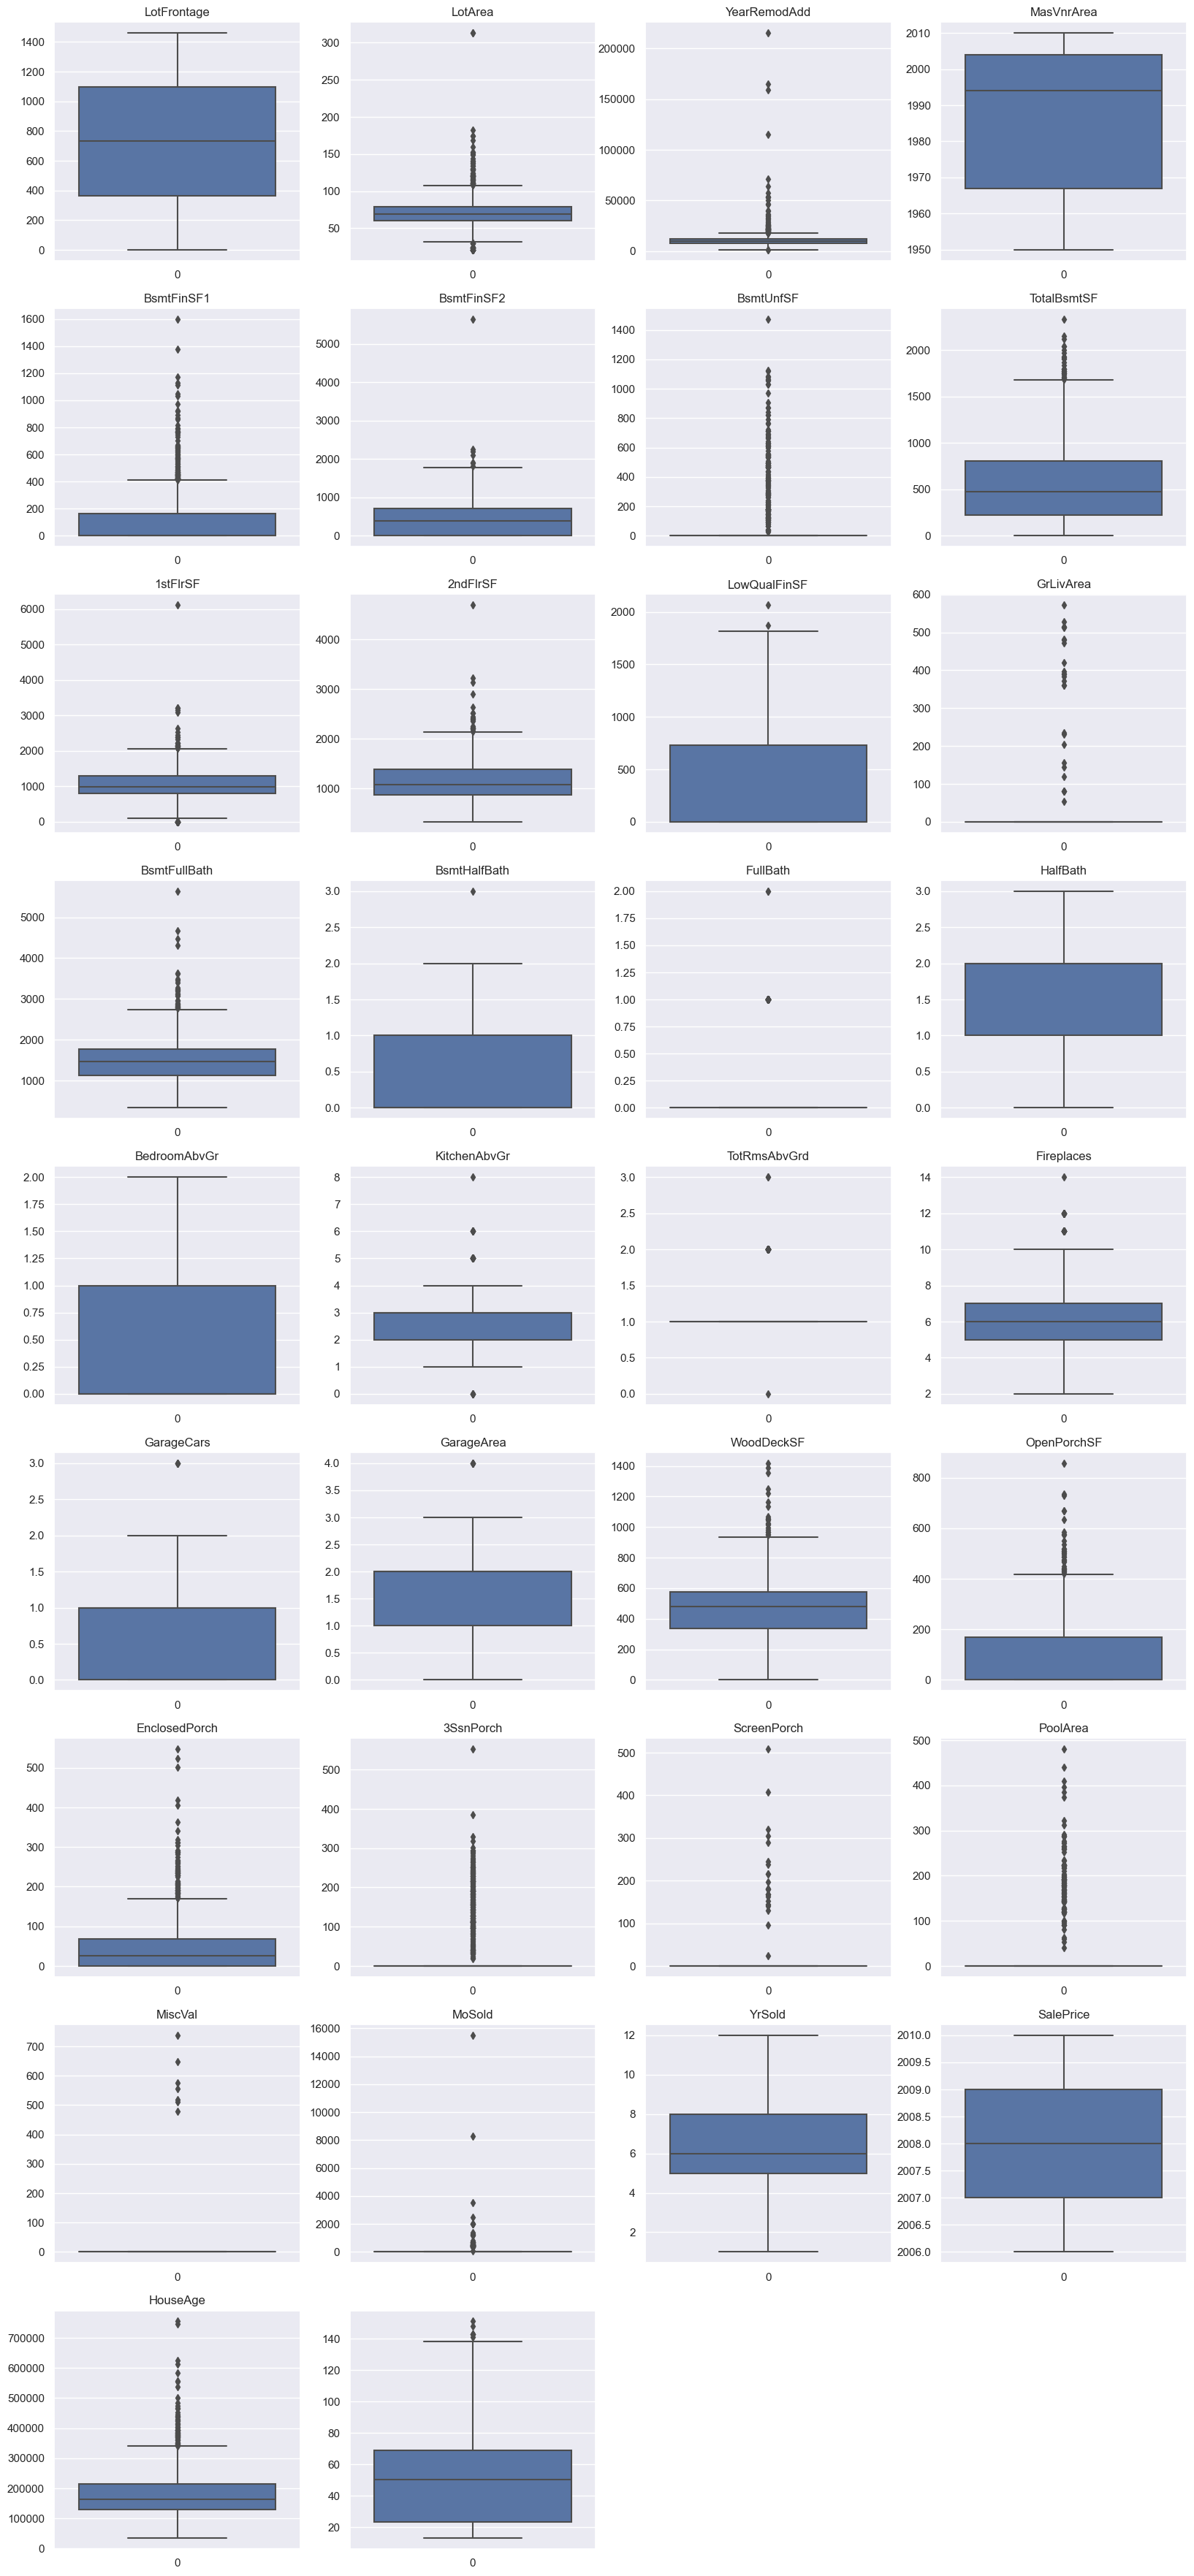

In [28]:
plt.figure(figsize=(20,50))
for i,val in enumerate(num_columns):
    plt.title(val)
    plt.subplot(10,4,i+1)
    sns.boxplot(train_df[val])

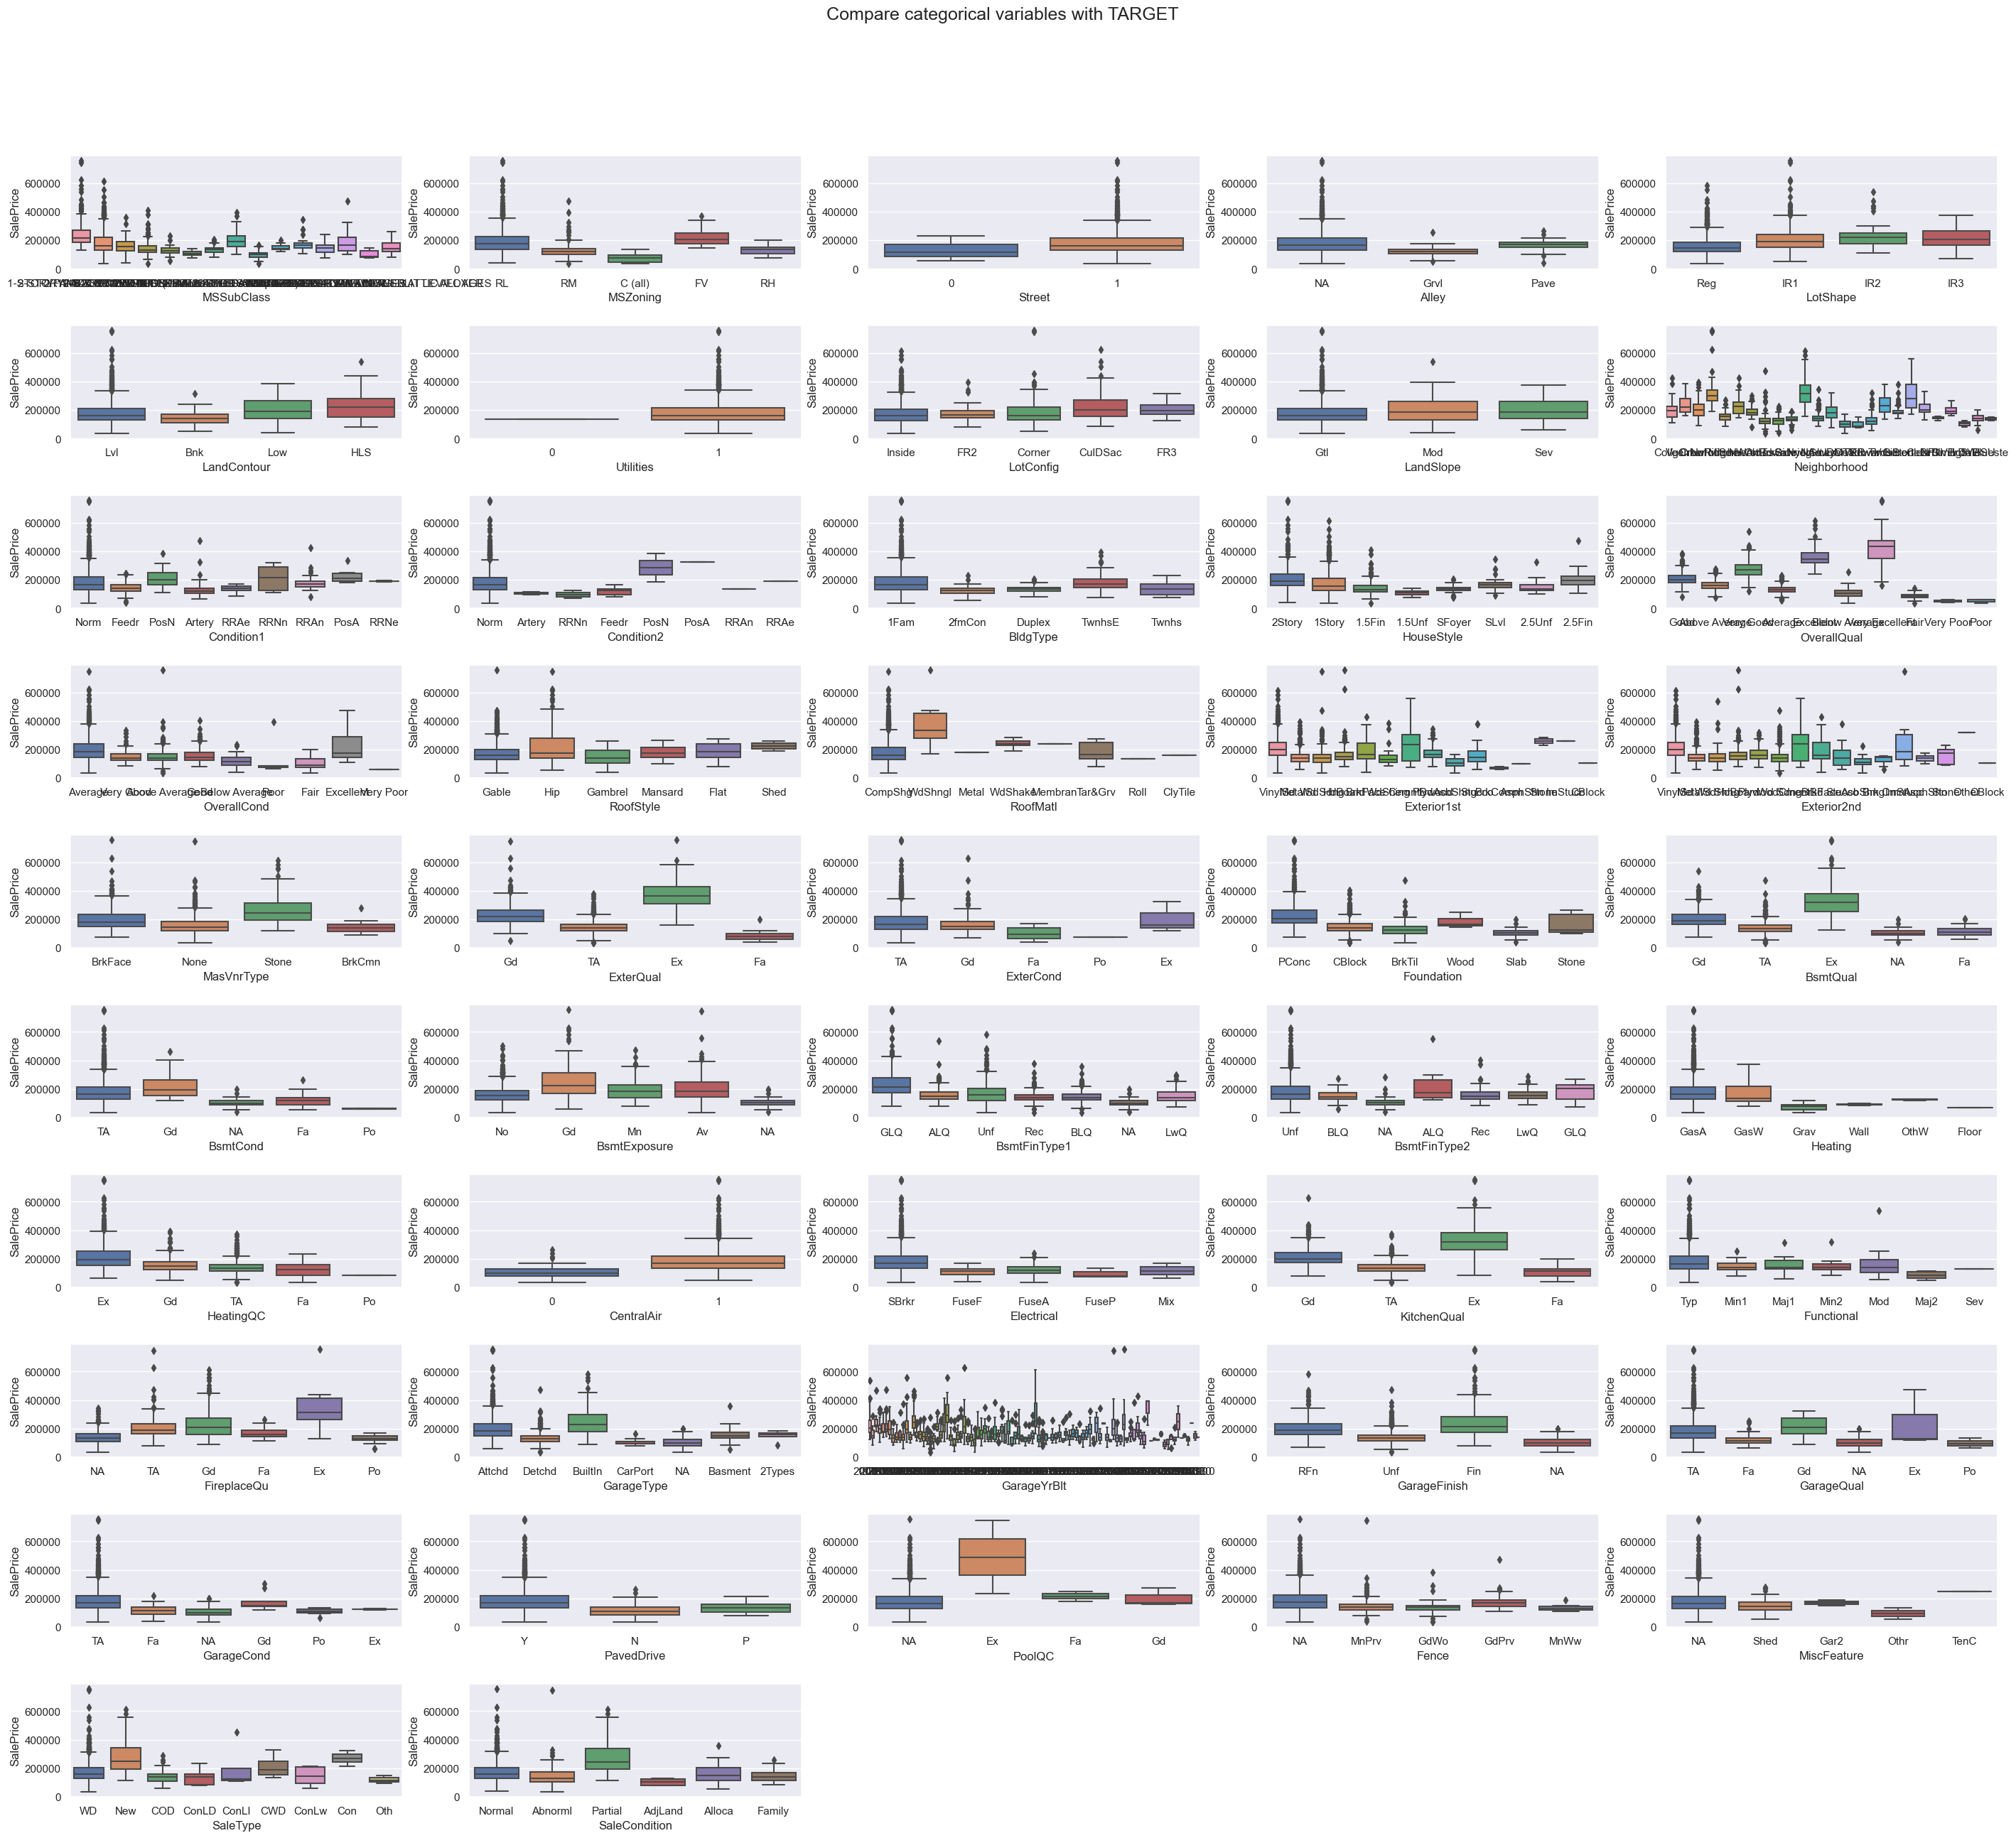

In [29]:
def run_boxplot(df, col): 
    # set the figure sizes, spaces, and fontsize
    plt.figure(figsize=(35, 30))
    plt.subplots_adjust(hspace=0.5)
    plt.suptitle("Compare categorical variables with TARGET", fontsize=18, y=0.95)

    # set number of columns (use 3 to demonstrate the change)
    ncols = col
    # calculate number of rows
    nrows = len(cat_columns) // ncols + (len(cat_columns) % ncols > 0)

    for n, m in enumerate(df[cat_columns]):
        # add a new subplot iteratively using nrows and cols
        ax = plt.subplot(nrows, ncols, n + 1)

        # filter df and plot ticker on the new subplot axis
        sns.boxplot(x=df[cat_columns[n]], y=df[TARGET], ax=ax)
        ax.set_xlabel(cat_columns[n])
        
run_boxplot(train_df,5)

## Handle Outliers

Use helper function to remove outliers greater than 1.5*IQR and less than 1.5*IQR


In [30]:
def outlier_treatment(datacolumn):
    sorted(datacolumn)
    Q1, Q3 = np.percentile(datacolumn , [25,75])
    IQR = Q3 - Q1
    lower_range = Q1 - (1.5 * IQR)
    upper_range = Q3 + (1.5 * IQR)
    return lower_range,upper_range

In [31]:
def remove_outliers(o):
    lowerbound,upperbound = outlier_treatment(train_df[o])
    train_df.drop(train_df[ (train_df[o] > upperbound) | (train_df[o] < lowerbound) ].index , inplace=True)

In [32]:
for i in (num_columns):
     remove_outliers(i)


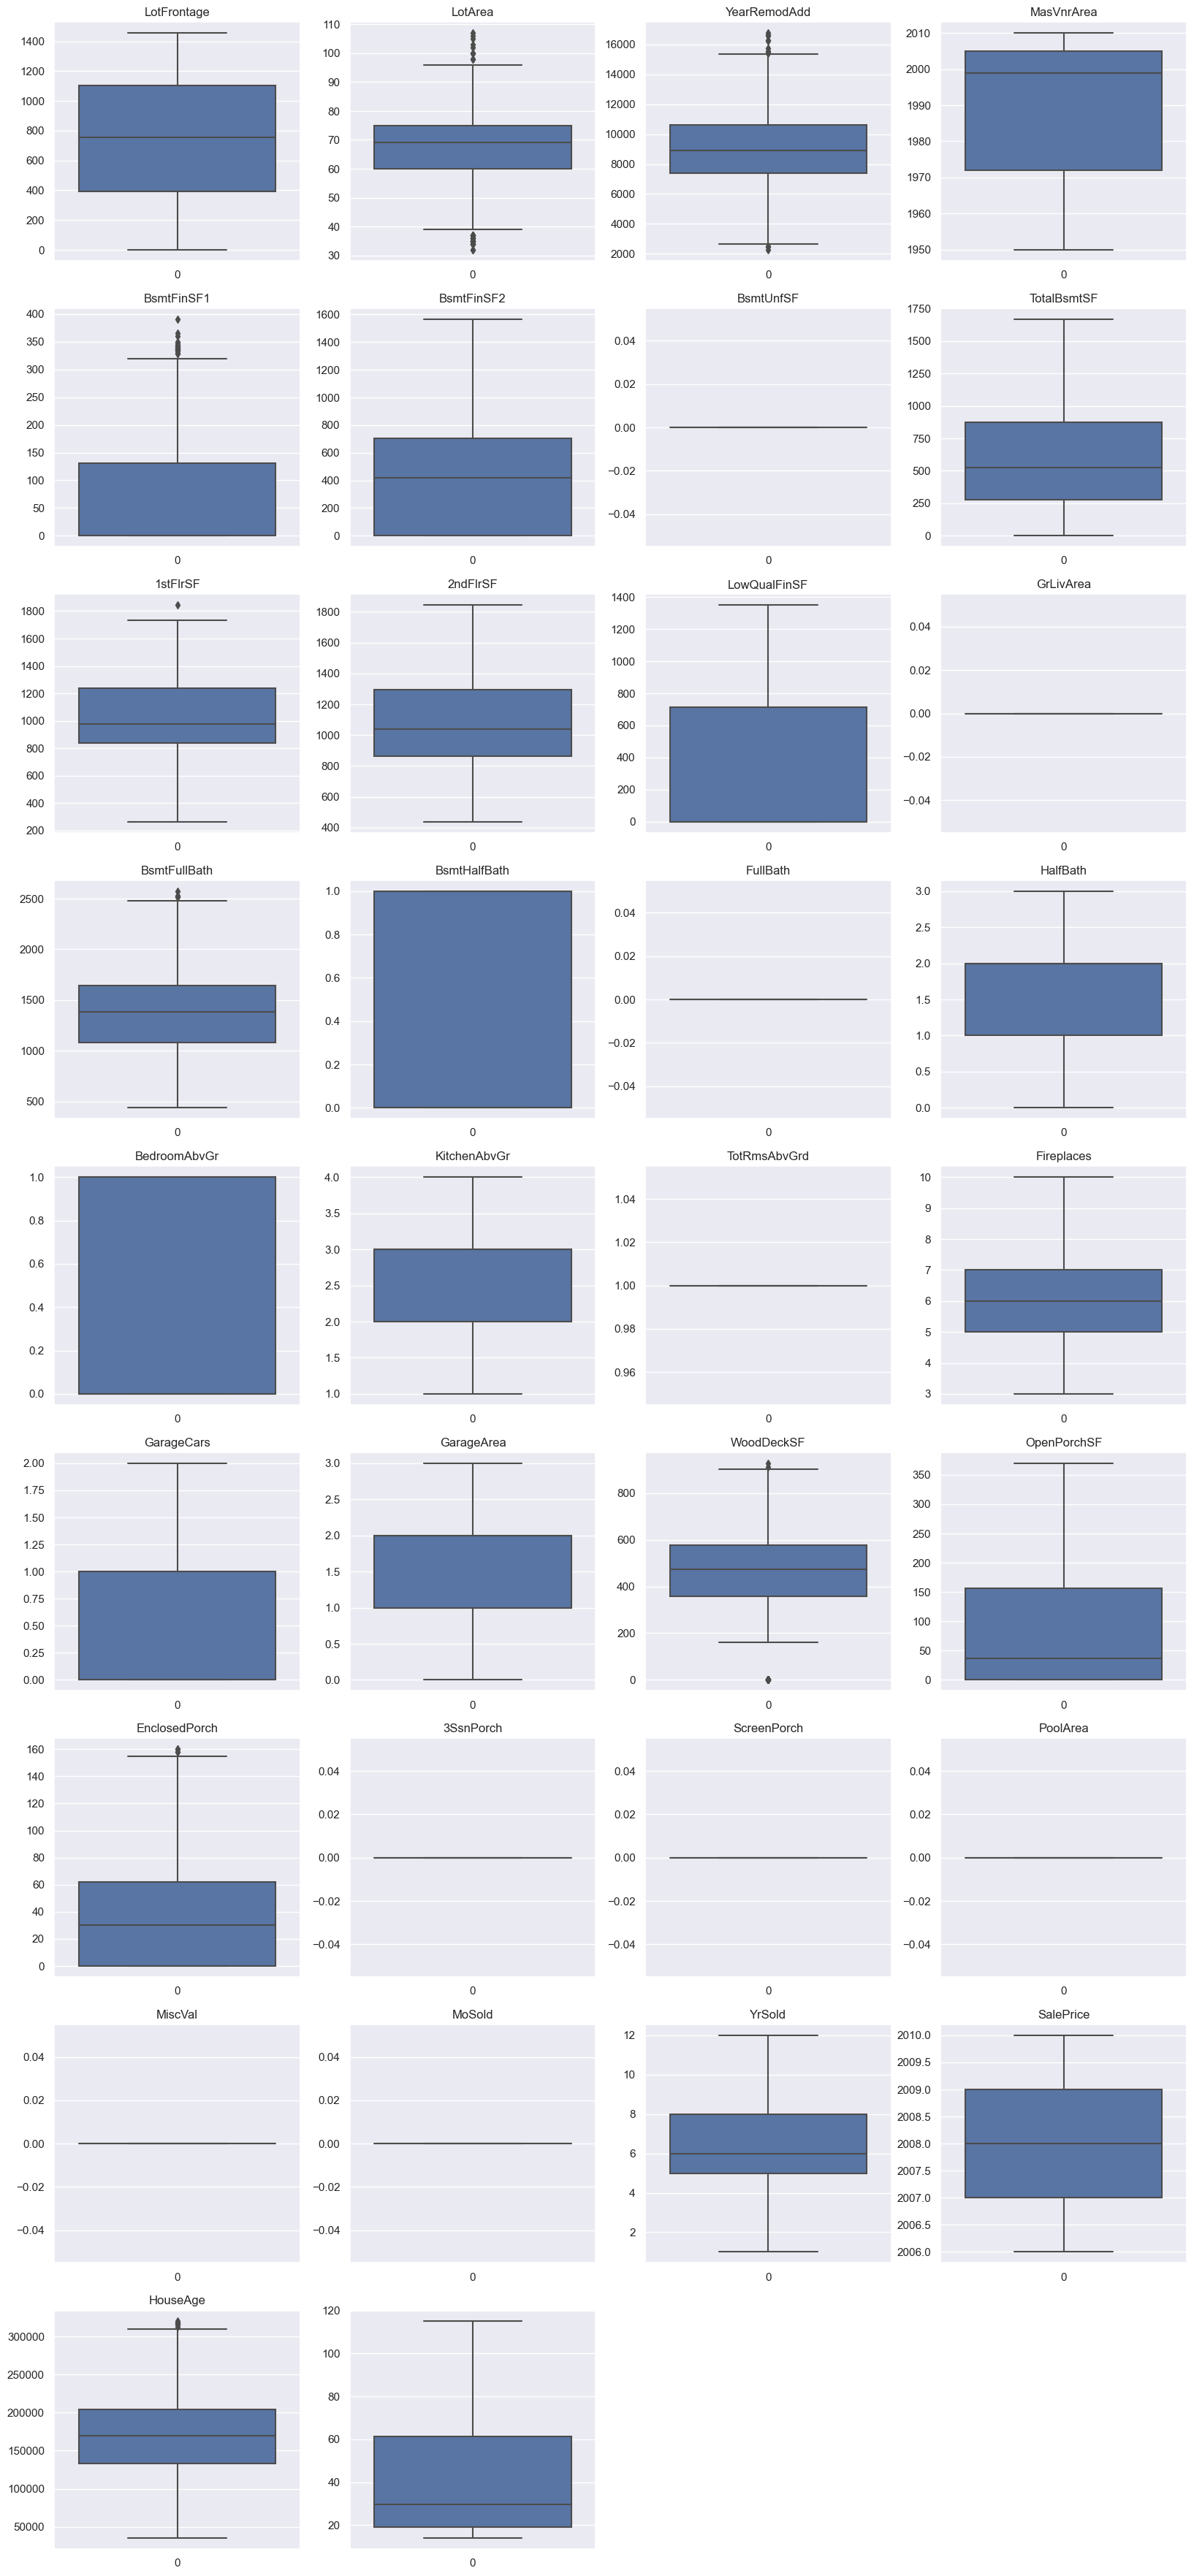

In [33]:
plt.figure(figsize=(20,50))
for i,val in enumerate(num_columns):
    plt.title(val)
    plt.subplot(10,4,i+1)
    sns.boxplot(train_df[val])

## Convert obj_columns into categories

In [34]:
CATEGORIES = [col for col in train_df if train_df.nunique()[col]<=16 and train_df.nunique()[col]>2]

for col in CATEGORIES:
    train_df[col]=train_df[col].astype('category')

## Analysis based on lmplot:

seaborn.lmplot() method is used to draw a scatter plot onto a FacetGrid. In our case, we're ordering / grouping by MSZoning. We're trying to see if there is linearity against SalePrice. While boxplot uses category data, lmplot uses numerical data.

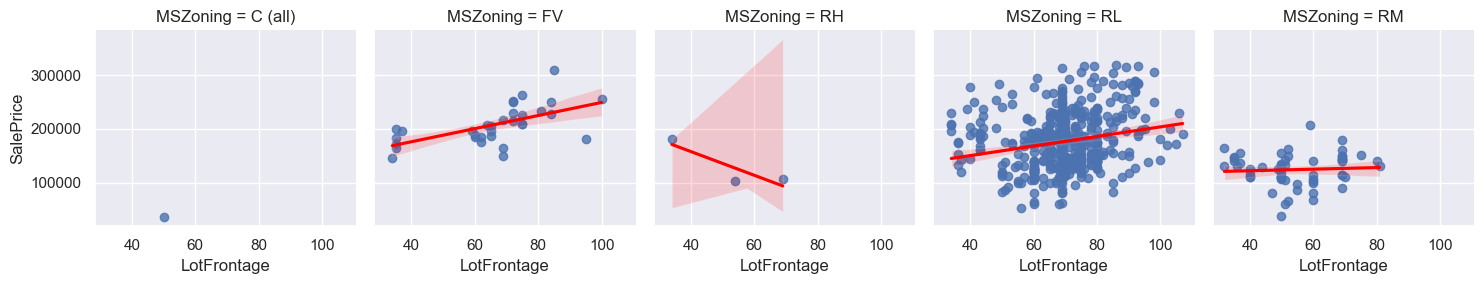

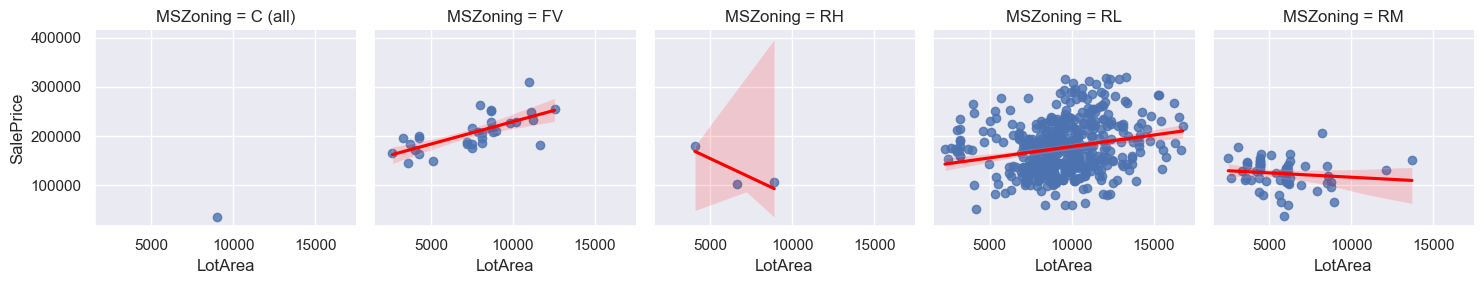

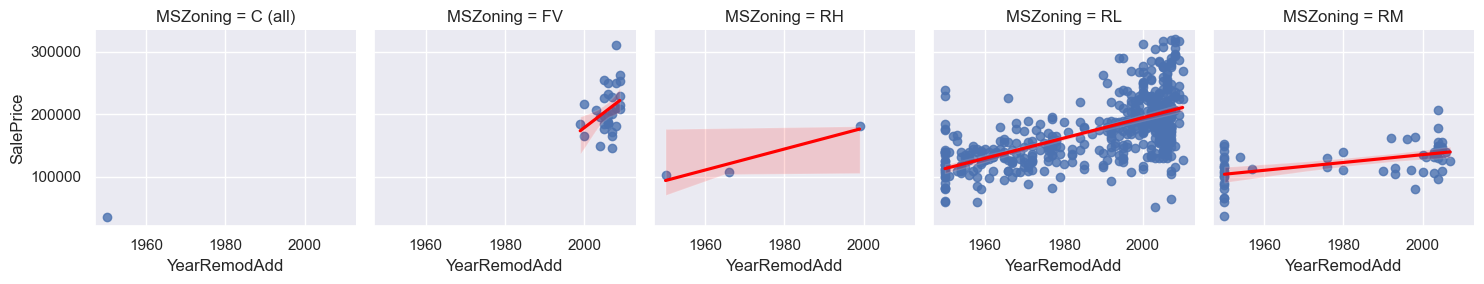

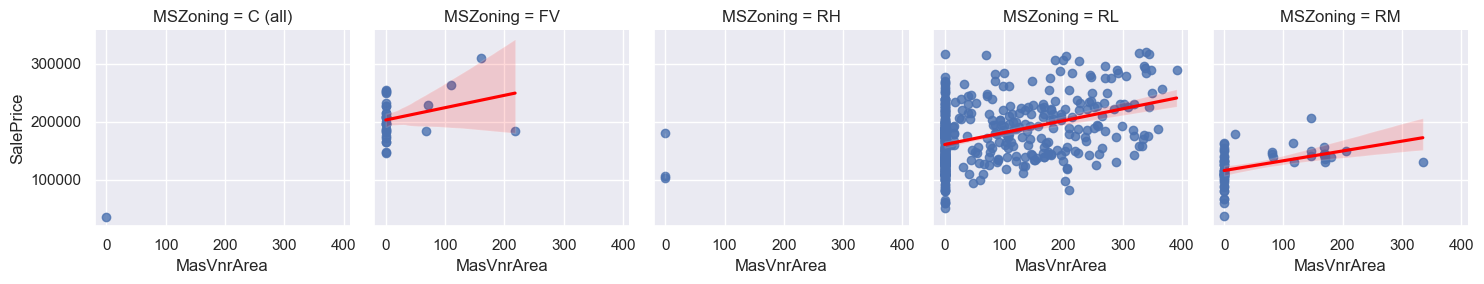

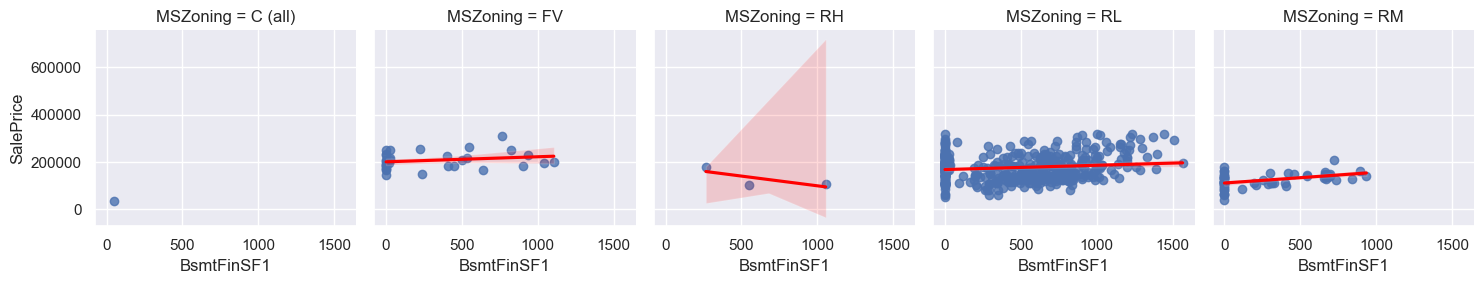

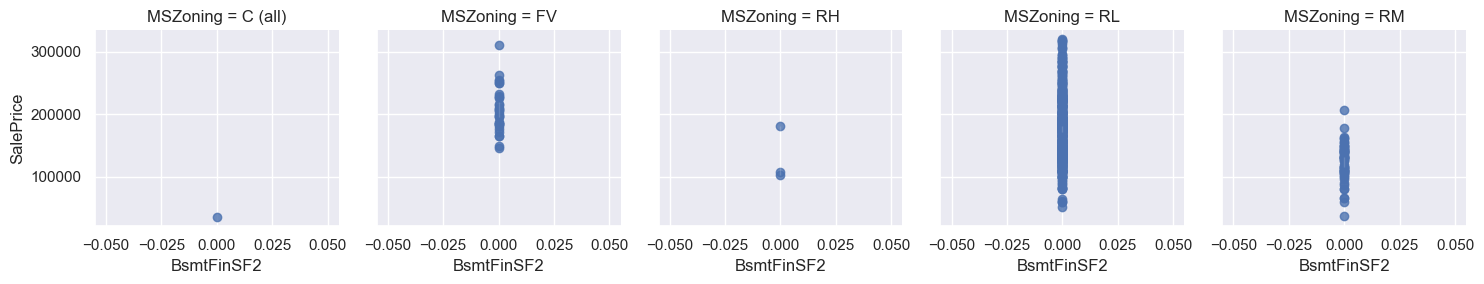

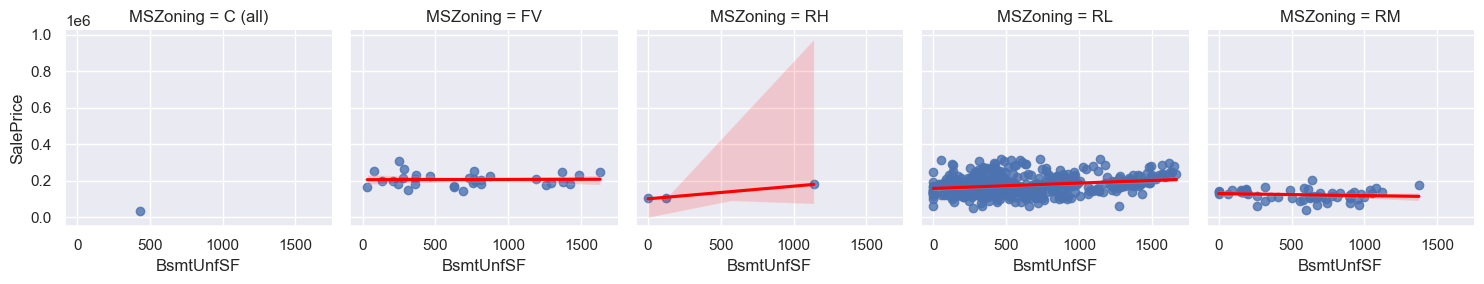

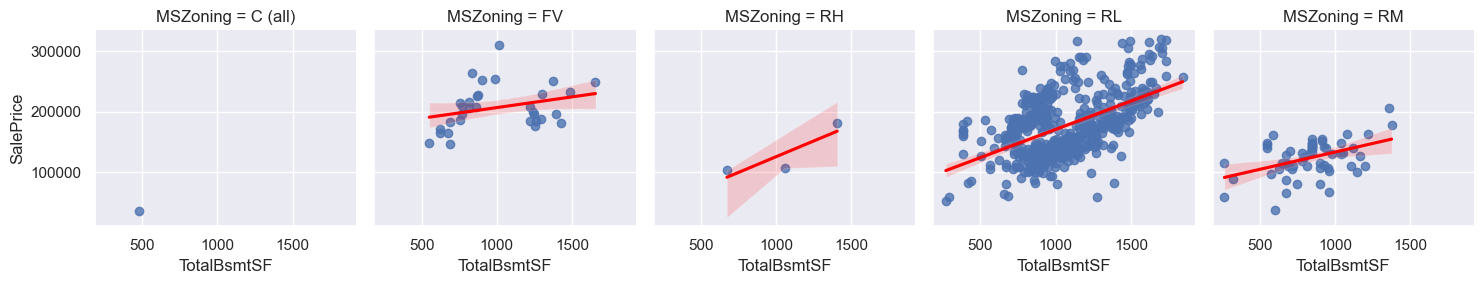

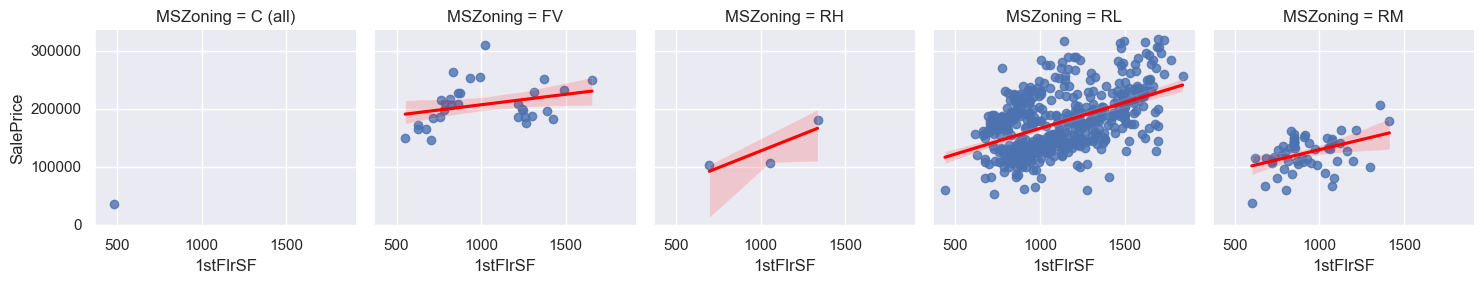

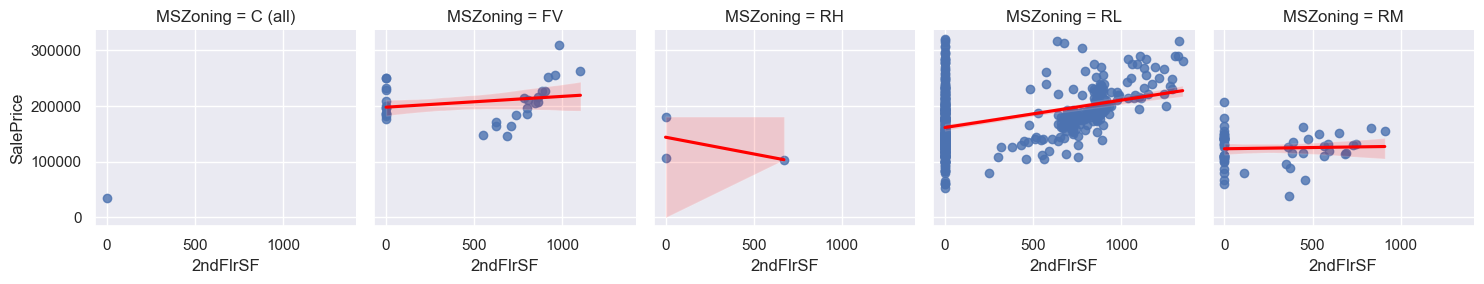

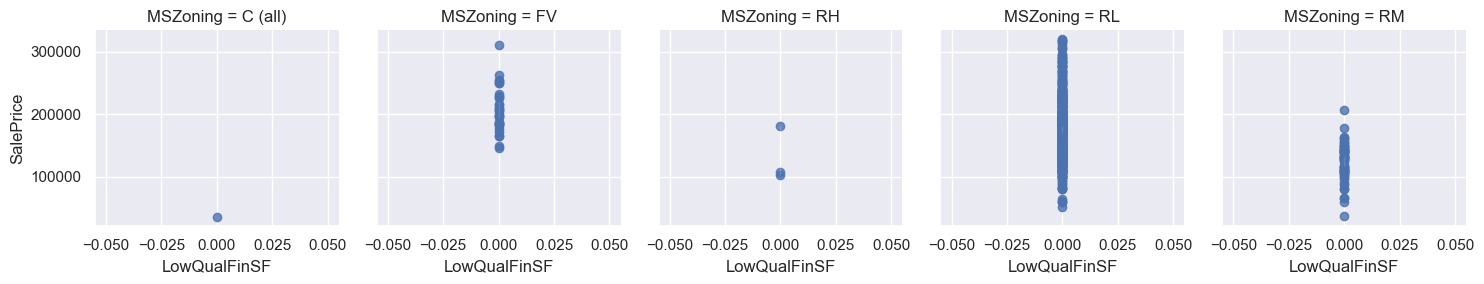

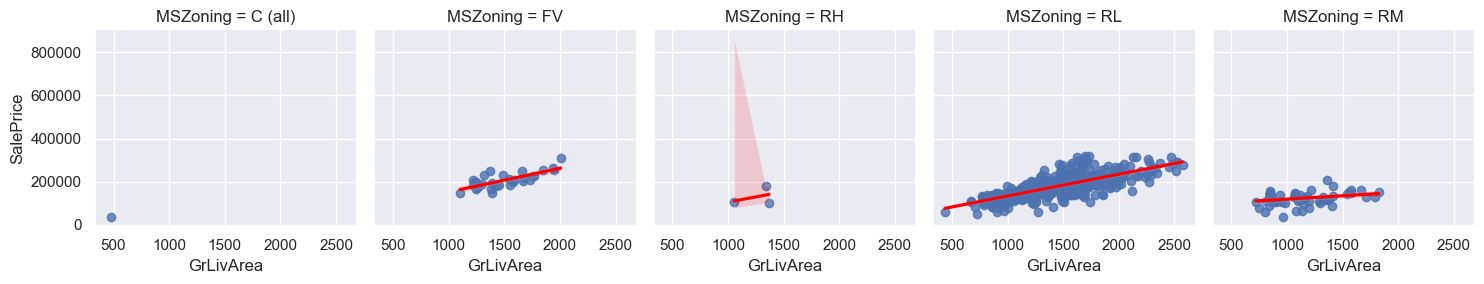

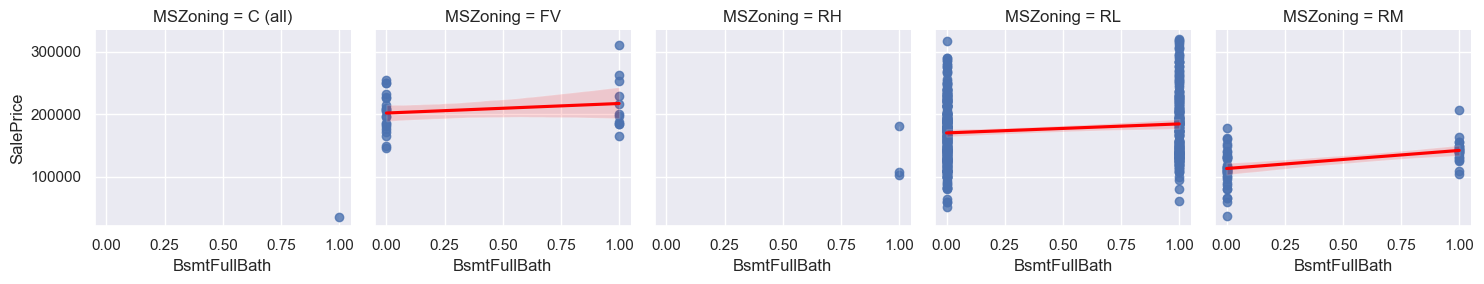

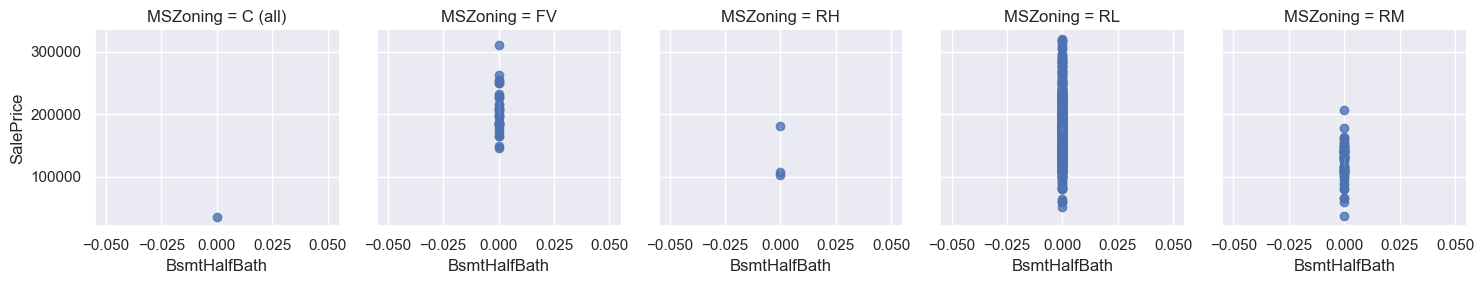

Urghhhhh.... something is wrong!


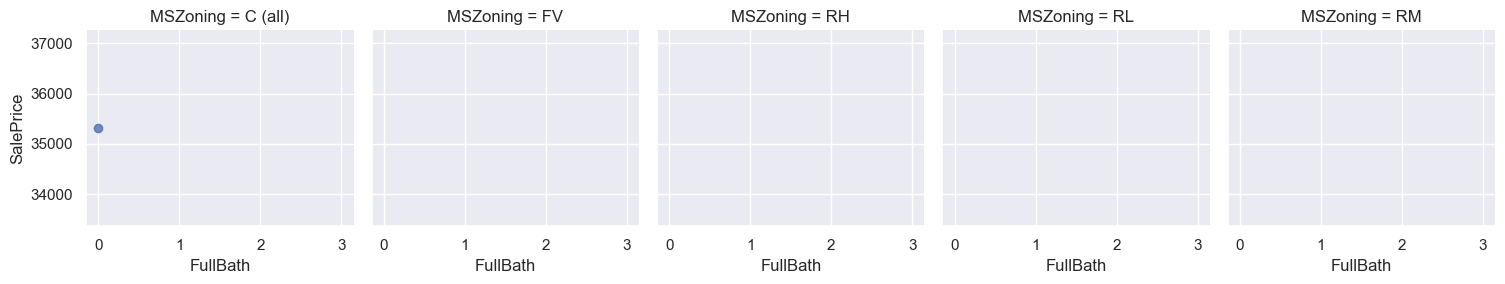

In [35]:
def run_lmplot(df): 
    try:
        for n in num_columns:
            if n != 'Id' and n != 'SalePrice':
                # plot the prediction in red  
                sns.lmplot(x=n, y=TARGET, data=df, order=1,
                           line_kws={'color':'red'}, height=3,
                           col="MSZoning"
                          )
                plt.show()
    except TypeError:
        print("Urghhhhh.... something is wrong!")
run_lmplot(train_df)

## Let's see if there are any correlations

Use heatmap to show correlation in numerical variables.  Dark and light colors are highly correlated.

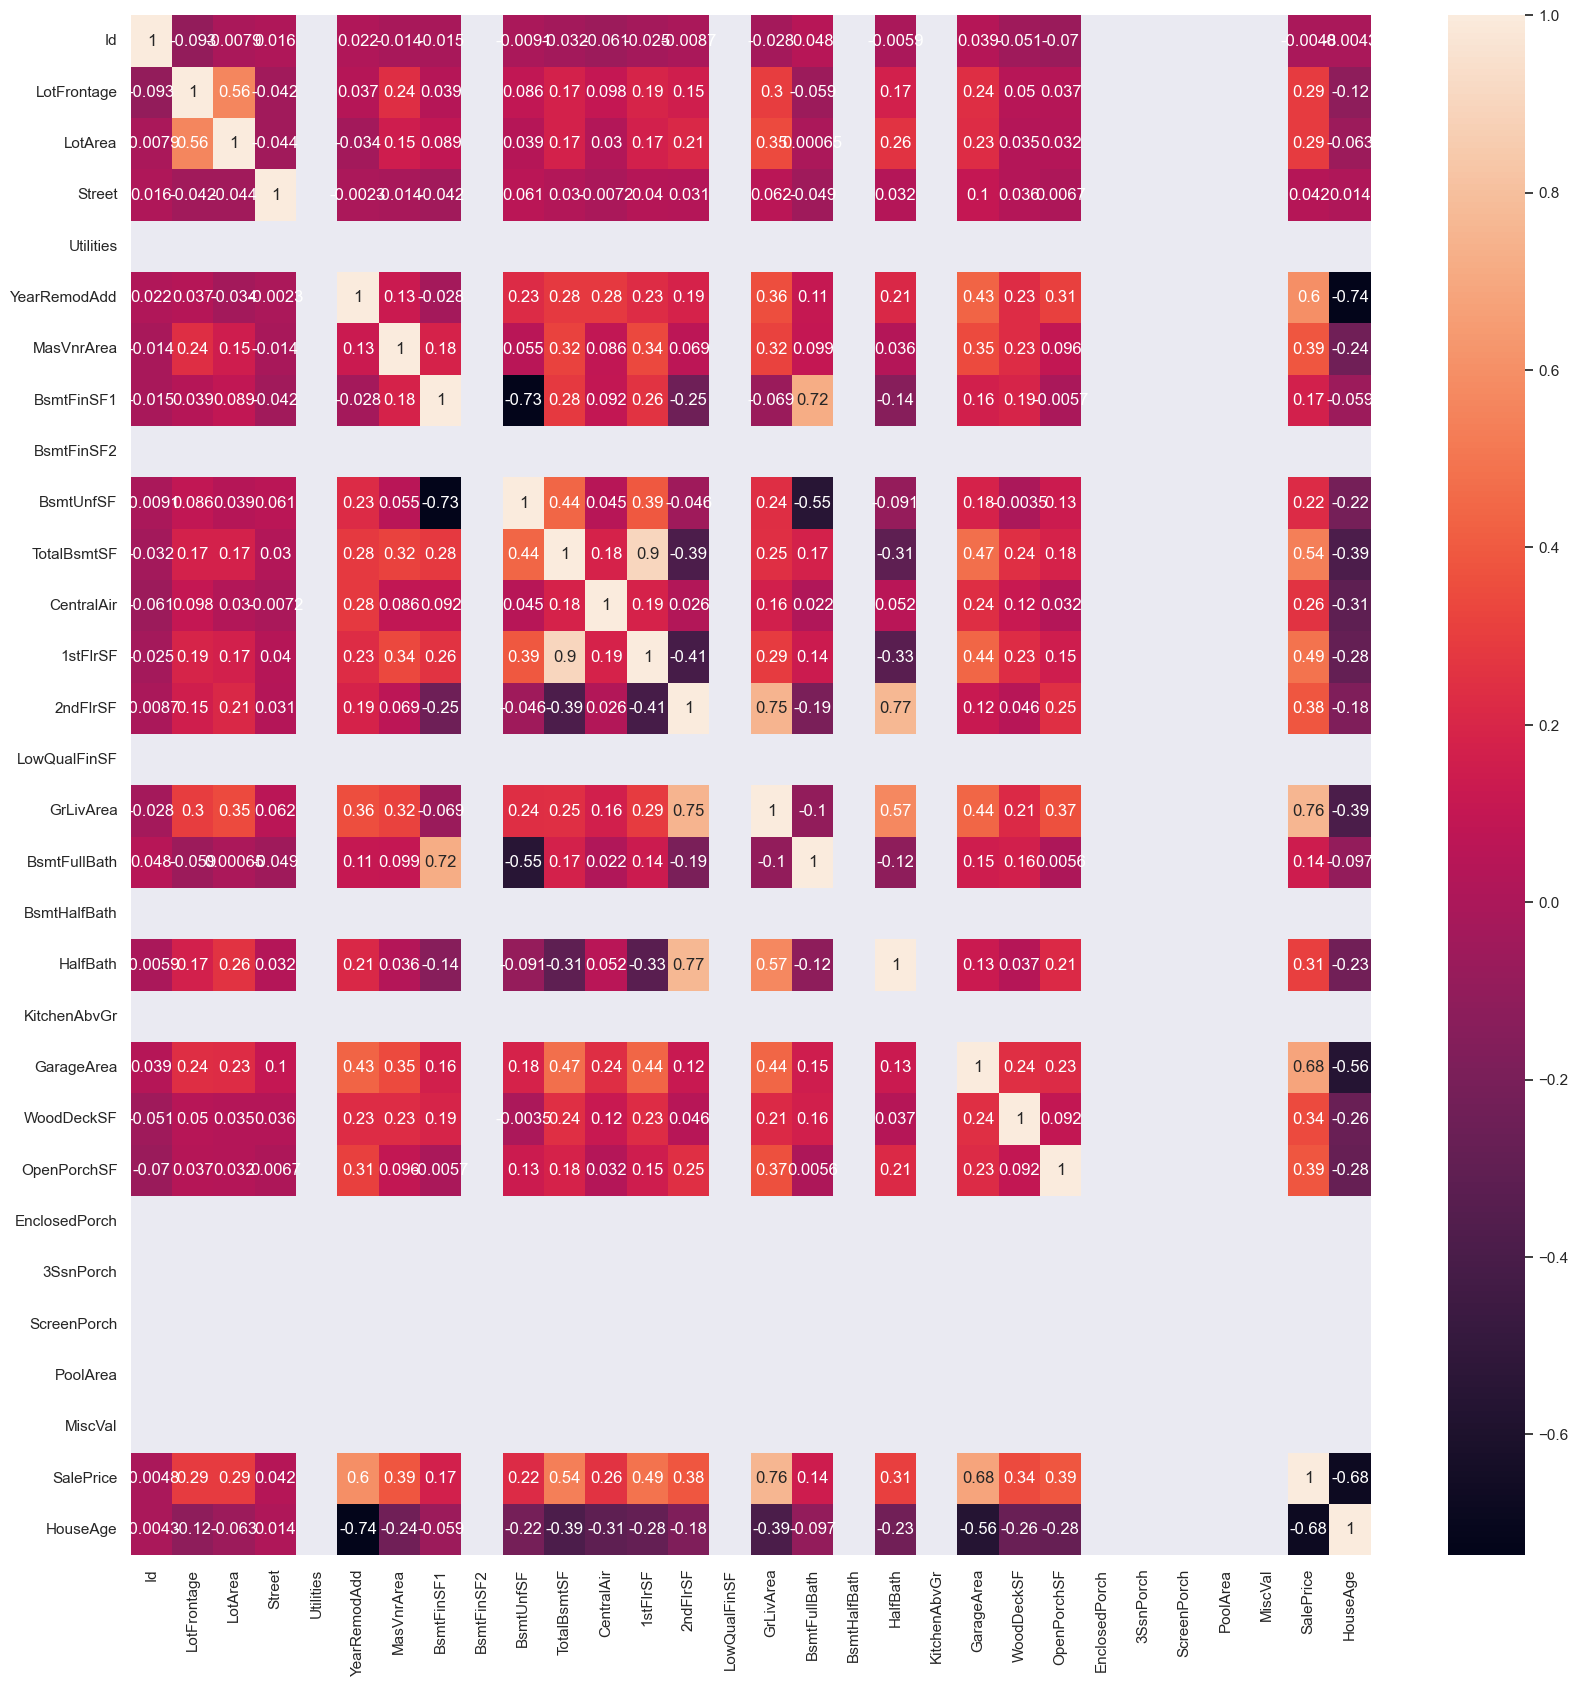

In [36]:
plt.subplots(figsize=(20,20))
sns.heatmap(train_df.corr(), annot=True, annot_kws={'size':12})
plt.show()

This is very difficult to assertain.  Let's plot it another way against TARGET value.  OverallQual an dGrLivArea are correlated.  We might have to drove one of the variables.

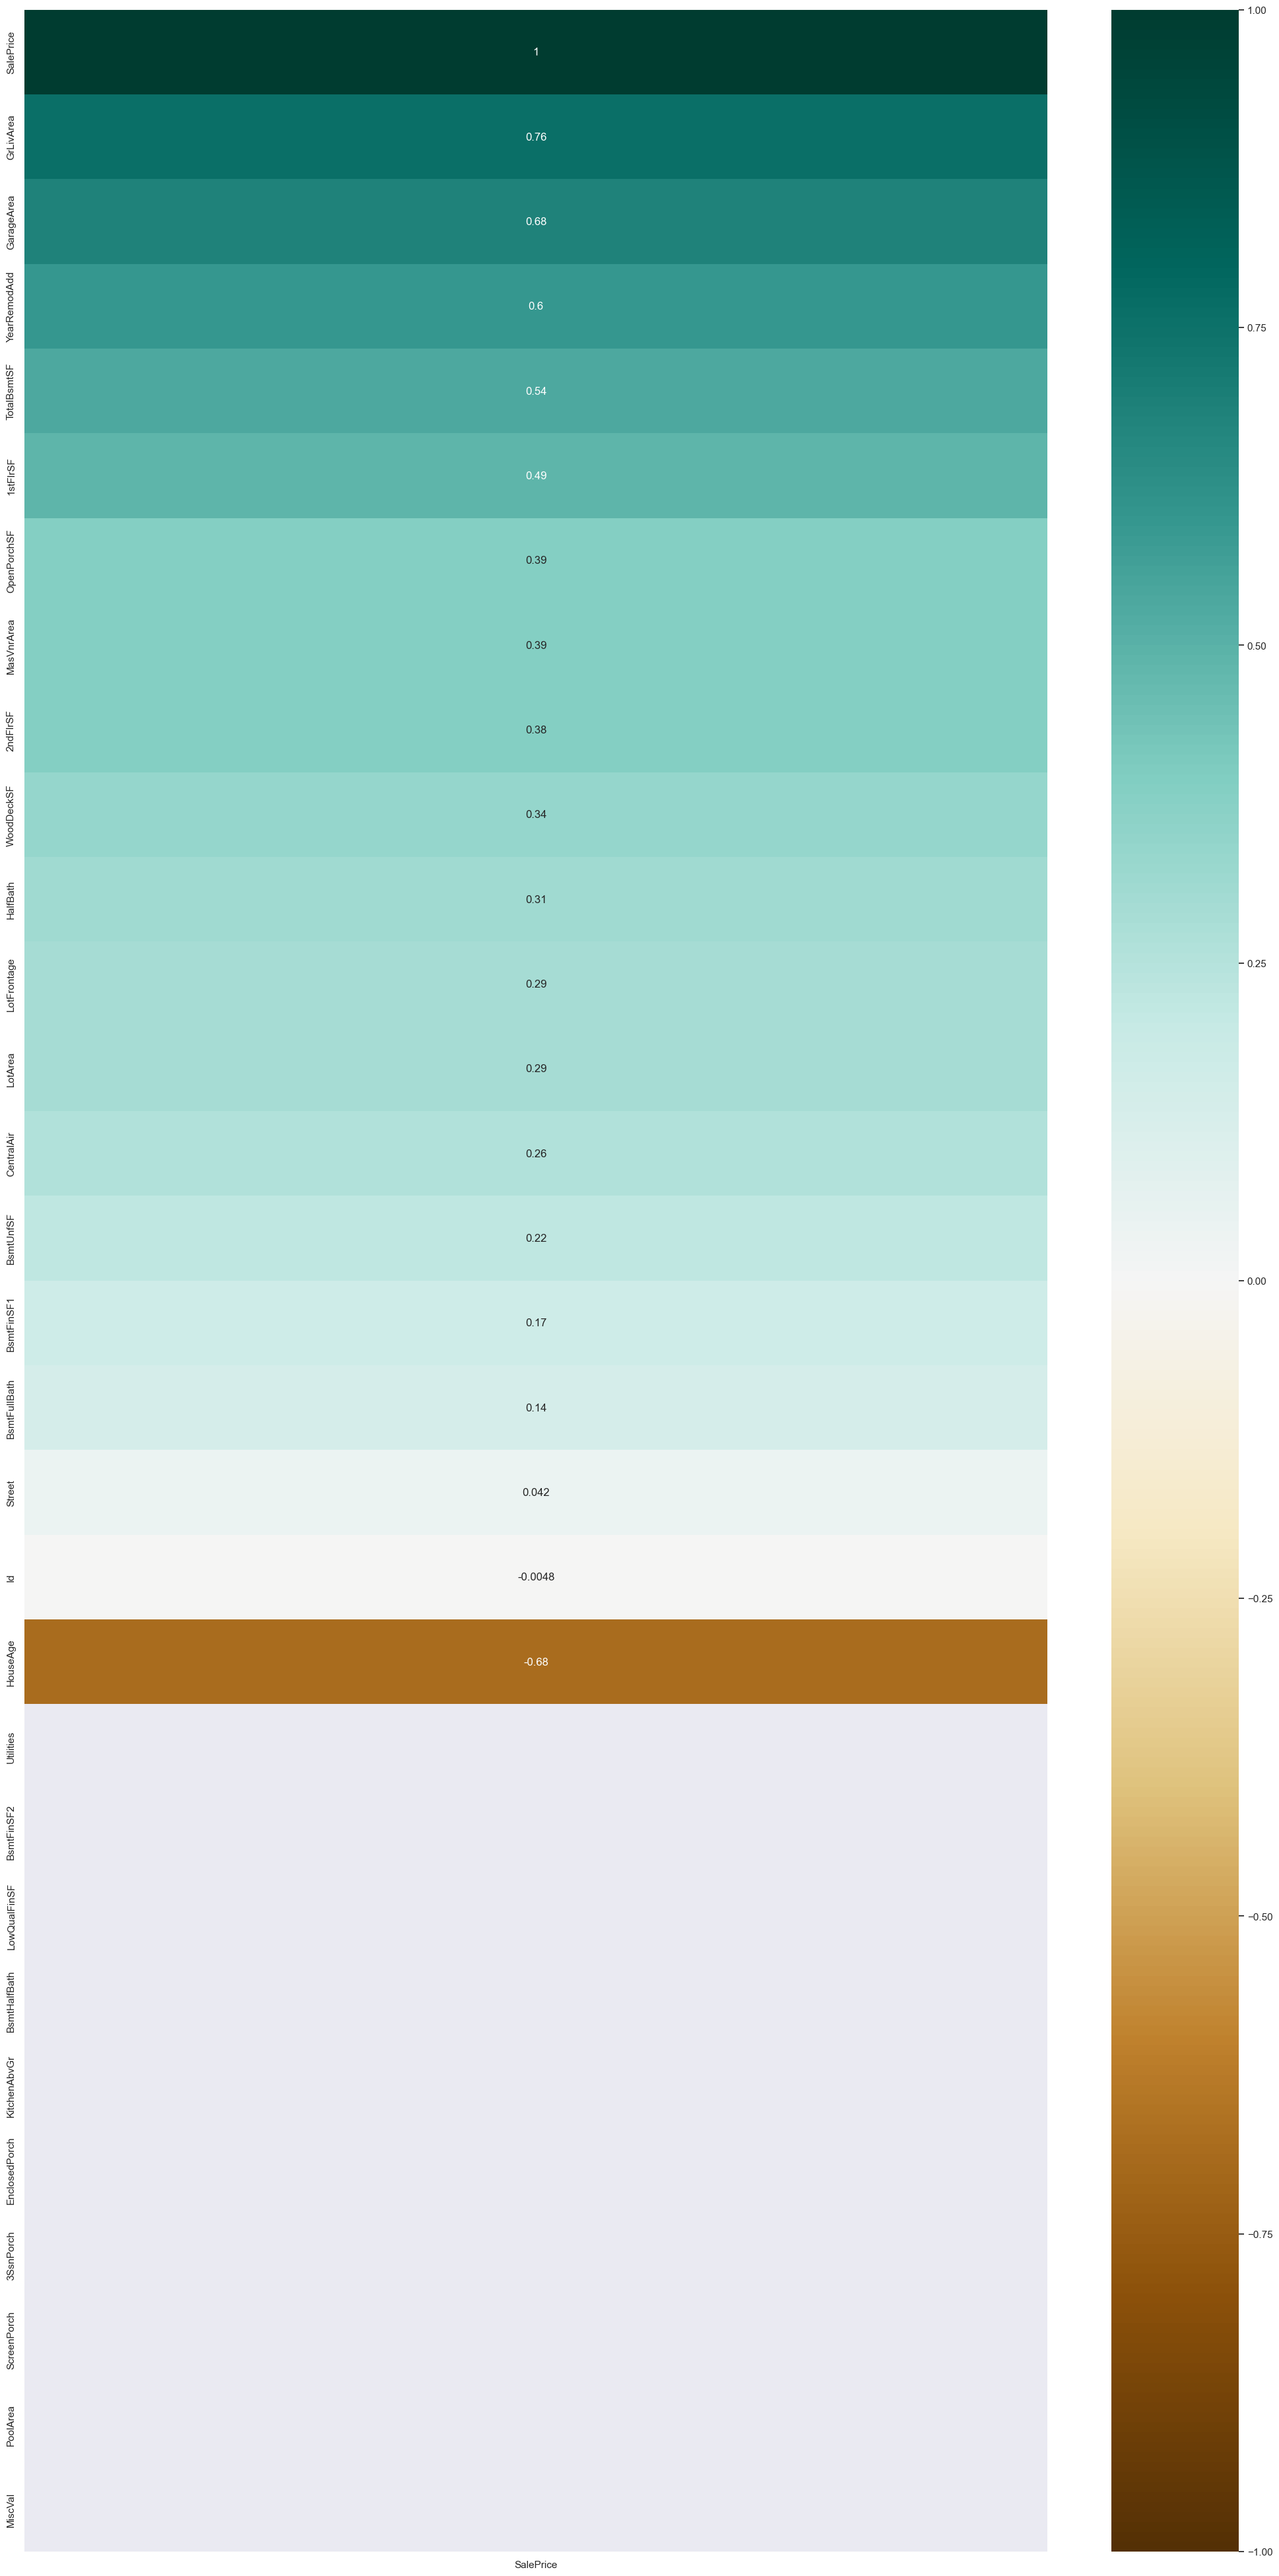

In [37]:
# Perform correlation against the TARGET ('cnt') variable
corr = train_df.corr()
plt.figure(figsize=(25, 50))
sns.heatmap(corr[[TARGET]].sort_values(by=TARGET, ascending=False), vmin=-1, annot=True, cmap='BrBG');
corr_order = corr[[TARGET]].sort_values(by=TARGET, ascending=False).index

## Drop unnecessary variables

In [38]:
train_df.drop(['Id'], axis=1, inplace=True)

In [39]:
train_df.head()

MSSubClass MSZoning  LotFrontage  LotArea  Street  \
0              2-STORY 1946 & NEWER       RL         65.0     8450       1   
2              2-STORY 1946 & NEWER       RL         68.0    11250       1   
4              2-STORY 1946 & NEWER       RL         84.0    14260       1   
6   1-STORY 1946 & NEWER ALL STYLES       RL         75.0    10084       1   
10  1-STORY 1946 & NEWER ALL STYLES       RL         70.0    11200       1   

   Alley LotShape LandContour  Utilities LotConfig LandSlope Neighborhood  \
0     NA      Reg         Lvl          1    Inside       Gtl      CollgCr   
2     NA      IR1         Lvl          1    Inside       Gtl      CollgCr   
4     NA      IR1         Lvl          1       FR2       Gtl      NoRidge   
6     NA      Reg         Lvl          1    Inside       Gtl      Somerst   
10    NA      Reg         Lvl          1    Inside       Gtl       Sawyer   

   Condition1 Condition2 BldgType HouseStyle OverallQual OverallCond  \
0        Norm       Norm     1Fam     2Story        Good     Average   
2        Norm       Norm     1Fam     2Story        Good     Average   
4        Norm       Norm     1Fam     2Story   Very Good     Average   
6        Norm       Norm     1Fam     1Story   Very Good     Average   
10       Norm       Norm     1Fam     1Story     Average     Average   

    YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0           2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   
2           2002     Gable  CompShg     VinylSd     VinylSd    BrkFace   
4           2000     Gable  CompShg     VinylSd     VinylSd    BrkFace   
6           2005     Gable  CompShg     VinylSd     VinylSd      Stone   
10          1965       Hip  CompShg     HdBoard     HdBoard       None   

    MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
0        196.0        Gd        TA      PConc       Gd       TA           No   
2        162.0        Gd        TA      PConc       Gd       TA           Mn   
4        350.0        Gd        TA      PConc       Gd       TA           Av   
6        186.0        Gd        TA      PConc       Ex       TA           Av   
10         0.0        TA        TA     CBlock       TA       TA           No   

   BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
0           GLQ         706          Unf           0        150          856   
2           GLQ         486          Unf           0        434          920   
4           GLQ         655          Unf           0        490         1145   
6           GLQ        1369          Unf           0        317         1686   
10          Rec         906          Unf           0        134         1040   

   Heating HeatingQC  CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
0     GasA        Ex           1      SBrkr       856       854             0   
2     GasA        Ex           1      SBrkr       920       866             0   
4     GasA        Ex           1      SBrkr      1145      1053             0   
6     GasA        Ex           1      SBrkr      1694         0             0   
10    GasA        Ex           1      SBrkr      1040         0             0   

    GrLivArea  BsmtFullBath  BsmtHalfBath FullBath  HalfBath BedroomAbvGr  \
0        1710             1             0        2         1            3   
2        1786             1             0        2         1            3   
4        2198             1             0        2         1            4   
6        1694             1             0        2         0            3   
10       1040             1             0        1         0            3   

    KitchenAbvGr KitchenQual TotRmsAbvGrd Functional Fireplaces FireplaceQu  \
0              1          Gd            8        Typ          0          NA   
2              1          Gd            6        Typ          1          TA   
4              1          Gd            9        Typ          1   

# Step 5: Scale the Data and create dummy variables

In [40]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()


DUMMIES = [x for x in train_df[cat_columns] if x not in BINARIES ]
DUMMY_COLS = pd.get_dummies(train_df[DUMMIES], drop_first=True)
train_df = pd.concat([train_df, DUMMY_COLS], axis=1)
train_df = train_df.drop(DUMMIES, axis=1)
train_df.head()

LotFrontage  LotArea  Street  Utilities  YearRemodAdd  MasVnrArea  \
0          65.0     8450       1          1          2003       196.0   
2          68.0    11250       1          1          2002       162.0   
4          84.0    14260       1          1          2000       350.0   
6          75.0    10084       1          1          2005       186.0   
10         70.0    11200       1          1          1965         0.0   

    BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  CentralAir  1stFlrSF  \
0          706           0        150          856           1       856   
2          486           0        434          920           1       920   
4          655           0        490         1145           1      1145   
6         1369           0        317         1686           1      1694   
10         906           0        134         1040           1      1040   

    2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath FullBath  \
0        854             0       1710             1             0        2   
2        866             0       1786             1             0        2   
4       1053             0       2198             1             0        2   
6          0             0       1694             1             0        2   
10         0             0       1040             1             0        1   

    HalfBath BedroomAbvGr  KitchenAbvGr TotRmsAbvGrd Fireplaces GarageCars  \
0          1            3             1            8          0          2   
2          1            3             1            6          1          2   
4          1            4             1            9          1          3   
6          0            3             1            7          1          2   
10         0            3             1            5          0          1   

    GarageArea  WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  \
0          548           0           61              0          0   
2          608           0           42              0          0   
4          836         192           84              0          0   
6          636         255           57              0          0   
10         384           0            0              0          0   

    ScreenPorch  PoolArea  MiscVal MoSold YrSold  SalePrice  HouseAge  \
0             0         0        0      2   2008     208500        20   
2             0         0        0      9   2008     223500        22   
4             0         0        0     12   2008     250000        23   
6             0         0        0      8   2007     307000        19   
10            0         0        0      2   2008     129500        58   

    MSSubClass_1-1/2 STORY FINISHED ALL AGES  MSSubClass_1-STORY 1945 & OLDER  \
0                                          0                                0   
2                                          0                                0   
4                                          0                                0   
6                                          0                                0   
10                                         0                                0   

    MSSubClass_1-STORY 1946 & NEWER ALL STYLES  \
0                                            0   
2                                            0   
4                                            0   
6                                            1   
10                                           1   

    MSSubClass_1-STORY PUD (Planned Unit Development) - 1946 & NEWER  \
0                                                   0                  
2                                                   0                  
4                                                   0                  
6                                                   0                  
10                                                  0                  

    MSSubClass_2 FAMILY CONVERSION - ALL STYLES AND AGES  \
0                                  

In [41]:
#Id is not useful in this case.  Let's drop it.
train_df.drop(['GrLivArea','GarageArea','YearRemodAdd','HouseAge','BsmtFinSF1'], axis=1, inplace=True)

In [42]:
EXCLUDE = pd.concat([train_df[BINARIES], train_df[DUMMY_COLS.columns]], axis=1).columns
SCALED = train_df.loc[:,~train_df.columns.isin(EXCLUDE)]

# Step 6: Train Test Split with RFE

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [44]:
train_df[SCALED.columns] = scaler.fit_transform(train_df[SCALED.columns])

In [45]:
X = train_df.drop([TARGET], axis=1)

In [46]:
y = train_df[TARGET]

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)

In [48]:
# train_df[TARGET] = np.log(train_df[TARGET])

In [49]:
lr_model = LinearRegression()
# model.fit(X_train, y_train)

# y_pred = model.predict(X_test)

# print('Standardized MSE: ', mean_squared_error(y_test, y_pred))
# print(f'R2: {r2_score(y_true=y_test, y_pred=y_pred)}')

In [50]:
rfe = RFE(lr_model,n_features_to_select=50)
rfe = rfe.fit(X_train,y_train)

In [51]:
col = X_train.columns[rfe.support_]


In [52]:
# list(zip(X_train.columns,rfe.support_,rfe.ranking_))
rfe_df = pd.DataFrame(list(zip(X_train.columns,rfe.support_,rfe.ranking_)), columns=['Variable', 'rfe_support', 'rfe_ranking'])
rfe_df = rfe_df.loc[rfe_df['rfe_support'] == True]
rfe_df.reset_index(drop=True, inplace=True)
rfe_df

Variable  rfe_support  \
0            MSSubClass_1-1/2 STORY FINISHED ALL AGES         True   
1                     MSSubClass_1-STORY 1945 & OLDER         True   
2   MSSubClass_2 FAMILY CONVERSION - ALL STYLES AN...         True   
3                     MSSubClass_2-STORY 1945 & OLDER         True   
4                     MSSubClass_2-STORY 1946 & NEWER         True   
5               MSSubClass_2-STORY PUD - 1946 & NEWER         True   
6             MSSubClass_DUPLEX - ALL STYLES AND AGES         True   
7   MSSubClass_PUD - MULTILEVEL - INCL SPLIT LEV/F...         True   
8                              MSSubClass_SPLIT FOYER         True   
9                                       LandSlope_Sev         True   
10                                    Condition1_RRNe         True   
11                                    Condition2_Norm         True   
12                                    BldgType_2fmCon         True   
13                                    BldgType_Duplex         True   
14                                  HouseStyle_1.5Unf         True   
15                                  HouseStyle_2Story         True   
16                              OverallCond_Very Poor         True   
17                                Exterior1st_BrkComm         True   
18                                Exterior1st_BrkFace         True   
19                                Exterior1st_CemntBd         True   
20                                Exterior1st_HdBoard         True   
21                                Exterior1st_MetalSd         True   
22                                Exterior1st_Plywood         True   
23                                 Exterior1st_Stucco         True   
24                                Exterior1st_VinylSd         True   
25                                Exterior1st_Wd Sdng         True   
26                                Exterior1st_WdShing         True   
27                                Exterior2nd_Brk Cmn         True   
28                                Exterior2nd_BrkFace         True   
29                                Exterior2nd_CmentBd         True   
30                                Exterior2nd_HdBoard         True   
31                                Exterior2nd_ImStucc         True   
32                                Exterior2nd_MetalSd         True   
33                                Exterior2nd_Plywood         True   
34                                  Exterior2nd_Stone         True   
35                                 Exterior2nd_Stucco         True   
36                                Exterior2nd_VinylSd         True   
37                                Exterior2nd_Wd Sdng         True   
38                                Exterior2nd_Wd Shng         True   
39                                        BsmtCond_Po         True   
40                                     Functional_Mod         True   
41                                      GarageType_NA         True   
42                                 GarageYrBlt_1929.0         True   
43                                   GarageYrBlt_1971         True   
44                                    GarageFinish_NA         True   
45                                      GarageQual_NA         True   
46                                      GarageQual_Po         True   
47                                      GarageCond_NA         True   
48                                   MiscFeature_Shed         True   
49                                       SaleType_Oth         True   

    rfe_ranking  
0             1  
1             1  
2             1  
3             1  
4             1  
5             1  
6             1  
7             1  
8             1  
9             1  
10            1  
11            1  
12            1  
13            1  
14            1  
15            1  
16            1  
17            1  
18            1  
19            1  
20            1  
21            1  
22            1  
23            1  
24            1  
25    

In [53]:
X_train_rfe = X_train[col]
X_train = X_train_rfe[X_train_rfe.columns]
X_test =  X_test[X_train.columns]

# Modeling Building and Evaluation

In [54]:
params = {'alpha': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 
                    9.0, 10.0, 20, 50, 100, 500, 1000 ]}

ridge = Ridge()

# cross validation

folds = 5

## Ridge Regression

In [55]:
ridge_model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
ridge_model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5,
                                   0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 4.0, 5.0,
                                   6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500,
                                   1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [99]:
# ridge_alpha = ridge_model_cv.best_params_.get('alpha')
ridge_alpha = 10.0

ridge = Ridge(alpha=ridge_alpha)
ridge.fit(X_train, y_train) 

Ridge(alpha=10.0)

In [100]:
ridge_df = pd.DataFrame({'Coefficient':ridge.coef_.round(3), 'Features':X_train.columns})
ridge_df = ridge_df[ridge_df['Coefficient'] != 0.00]
ridge_df.reset_index(drop=True, inplace=True)
ridge_df

Coefficient                                           Features
0        -0.211           MSSubClass_1-1/2 STORY FINISHED ALL AGES
1        -0.566                    MSSubClass_1-STORY 1945 & OLDER
2        -0.097  MSSubClass_2 FAMILY CONVERSION - ALL STYLES AN...
3         0.017                    MSSubClass_2-STORY 1945 & OLDER
4         0.381                    MSSubClass_2-STORY 1946 & NEWER
5        -0.123              MSSubClass_2-STORY PUD - 1946 & NEWER
6        -0.021            MSSubClass_DUPLEX - ALL STYLES AND AGES
7        -0.180  MSSubClass_PUD - MULTILEVEL - INCL SPLIT LEV/F...
8        -0.141                             MSSubClass_SPLIT FOYER
9        -0.014                                      LandSlope_Sev
10       -0.097                                    BldgType_2fmCon
11       -0.021                                    BldgType_Duplex
12       -0.101                                  HouseStyle_1.5Unf
13        0.213                                  HouseStyle_2Story
14       -0.014                              OverallCond_Very Poor
15       -0.140                                Exterior1st_BrkComm
16        0.061                                Exterior1st_BrkFace
17        0.523                                Exterior1st_CemntBd
18       -0.104                                Exterior1st_HdBoard
19       -0.132                                Exterior1st_MetalSd
20        0.030                                Exterior1st_Plywood
21       -0.042                                 Exterior1st_Stucco
22        0.232                                Exterior1st_VinylSd
23       -0.049                                Exterior1st_Wd Sdng
24       -0.102                                Exterior1st_WdShing
25       -0.140                                Exterior2nd_Brk Cmn
26       -0.049                                Exterior2nd_BrkFace
27        0.540                                Exterior2nd_CmentBd
28       -0.083                                Exterior2nd_HdBoard
29       -0.035                                Exterior2nd_ImStucc
30       -0.069                                Exterior2nd_MetalSd
31       -0.178                                Exterior2nd_Plywood
32        0.046                                  Exterior2nd_Stone
33        0.069                                 Exterior2nd_Stucco
34        0.324                                Exterior2nd_VinylSd
35       -0.120                                Exterior2nd_Wd Sdng
36       -0.028                                Exterior2nd_Wd Shng
37       -0.090                                        BsmtCond_Po
38       -0.140                                     Functional_Mod
39       -0.164                                      GarageType_NA
40        0.046                                 GarageYrBlt_1929.0
41       -0.164                                   GarageYrBlt_1971
42       -0.164                                    GarageFinish_NA
43       -0.164                                      GarageQual_NA
44       -0.076                                      GarageQual_Po
45       -0.164                                      GarageCond_NA
46       -0.047                                   MiscFeature_Shed
47       -0.047                                       SaleType_Oth

In [101]:
X_train_ridge = X_train[ridge_df.Features]

lm = LinearRegression()
lm.fit(X_train_ridge, y_train)

rfe = RFE(lm, n_features_to_select=5)            
rfe = rfe.fit(X_train_ridge, y_train)

In [102]:
pd.DataFrame(list(zip( X_train_ridge.columns, rfe.support_, rfe.ranking_)), columns=['Features', 'rfe_support', 'rfe_ranking'])


Features  rfe_support  \
0            MSSubClass_1-1/2 STORY FINISHED ALL AGES        False   
1                     MSSubClass_1-STORY 1945 & OLDER        False   
2   MSSubClass_2 FAMILY CONVERSION - ALL STYLES AN...        False   
3                     MSSubClass_2-STORY 1945 & OLDER        False   
4                     MSSubClass_2-STORY 1946 & NEWER        False   
5               MSSubClass_2-STORY PUD - 1946 & NEWER        False   
6             MSSubClass_DUPLEX - ALL STYLES AND AGES        False   
7   MSSubClass_PUD - MULTILEVEL - INCL SPLIT LEV/F...        False   
8                              MSSubClass_SPLIT FOYER        False   
9                                       LandSlope_Sev        False   
10                                    BldgType_2fmCon        False   
11                                    BldgType_Duplex        False   
12                                  HouseStyle_1.5Unf        False   
13                                  HouseStyle_2Story        False   
14                              OverallCond_Very Poor        False   
15                                Exterior1st_BrkComm         True   
16                                Exterior1st_BrkFace        False   
17                                Exterior1st_CemntBd        False   
18                                Exterior1st_HdBoard        False   
19                                Exterior1st_MetalSd        False   
20                                Exterior1st_Plywood        False   
21                                 Exterior1st_Stucco        False   
22                                Exterior1st_VinylSd        False   
23                                Exterior1st_Wd Sdng        False   
24                                Exterior1st_WdShing        False   
25                                Exterior2nd_Brk Cmn        False   
26                                Exterior2nd_BrkFace        False   
27                                Exterior2nd_CmentBd         True   
28                                Exterior2nd_HdBoard        False   
29                                Exterior2nd_ImStucc        False   
30                                Exterior2nd_MetalSd        False   
31                                Exterior2nd_Plywood        False   
32                                  Exterior2nd_Stone        False   
33                                 Exterior2nd_Stucco        False   
34                                Exterior2nd_VinylSd         True   
35                                Exterior2nd_Wd Sdng        False   
36                                Exterior2nd_Wd Shng        False   
37                                        BsmtCond_Po        False   
38                                     Functional_Mod        False   
39                                      GarageType_NA         True   
40                                 GarageYrBlt_1929.0        False   
41                                   GarageYrBlt_1971        False   
42                                    GarageFinish_NA        False   
43                                      GarageQual_NA        False   
44                                      GarageQual_Po         True   
45                                      GarageCond_NA        False   
46                                   MiscFeature_Shed        False   
47                                       SaleType_Oth        False   

    rfe_ranking  
0            44  
1            41  
2            38  
3            34  
4            32  
5            35  
6            28  
7            40  
8            42  
9            22  
10           39  
11           27  
12           43  
13           36  
14           25  
15            1  
16            7  
17            5  
18           10  
19           23  
20            9  
21           18  
22           15  
23           12  
24           26  
25           16  
26           30  
27            1  
28           24  
29           17  
30           11  
31           31  
32            4  
33

In [126]:
# X_train_rfe = X_train[col]
X_train_rfe = sm.add_constant(X_train_ridge)
rfe_model = sm.OLS(y_train, X_train_rfe).fit()
rfe_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.511
Model:                            OLS   Adj. R-squared:                  0.472
Method:                 Least Squares   F-statistic:                     13.26
Date:                Wed, 01 Feb 2023   Prob (F-statistic):           4.27e-48
Time:                        02:08:45   Log-Likelihood:                -501.28
No. Observations:                 467   AIC:                             1073.
Df Residuals:                     432   BIC:                             1218.
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                   -0.9115      0.385     -2.365      0.018      -1.669      -0.154
MSSubClass_1-1/2 STORY FINISHED ALL AGES                -0.3567      0.152     -2.343      0.020      -0.656      -0.058
MSSubClass_1-STORY 1945 & OLDER                         -0.9458      0.205     -4.616      0.000      -1.349      -0.543
MSSubClass_2 FAMILY CONVERSION - ALL STYLES AND AGES    -0.2556      0.171     -1.491      0.137      -0.593       0.081
MSSubClass_2-STORY 1945 & OLDER                          0.0176      0.330      0.053      0.957      -0.630       0.666
MSSubClass_2-STORY 1946 & NEWER                          0.5252      0.261      2.009      0.045       0.011       1.039
MSSubClass_2-STORY PUD - 1946 & NEWER                   -0.1646      0.336     -0.491      0.624      -0.824       0.495
MSSubClass_DUPLEX - ALL STYLES AND AGES                 -0.0672      0.219     -0.307      0.759      -0.498       0.363
MSSubClass_PUD - MULTILEVEL - INCL SPLIT LEV/FOYER      -0.8121      0.430     -1.890      0.059      -1.657       0.032
MSSubClass_SPLIT FOYER                                  -0.3908      0.223     -1.756      0.080      -0.828       0.047
LandSlope_Sev                                            0.0665      0.339      0.196      0.845      -0.600       0.733
BldgType_2fmCon                                         -0.2556      0.171     -1.491      0.137      -0.593       0.081
BldgType_Duplex                                         -0.0672      0.219     -0.307      0.759      -0.498       0.363
HouseStyle_1.5Unf                                       -0.5141      0.467     -1.100      0.272      -1.433       0.404
HouseStyle_2Story                                        0.0627      0.253      0.248      0.804      -0.434       0.559
OverallCond_Very Poor                                    0.0665      0.339      0.196      0.845      -0.600       0.733
Exterior1st_BrkComm                                     -0.4076      0.277     -1.472      0.142      -0.952       0.137
Exterior1st_BrkFace                                      0.6288      0.372      1.691      0.092      -0.102       1.360
Exterior1st_CemntBd                                      0.7410      0.747      0.992      0.322      -0.727       2.209
Exterior1st_HdBoard                                      0.4788      0.314      1.527      0.128      -0.138       1.095
Exterior1st_MetalSd                                      0.1015      0.534      0.190      0.849      -0.948       1.151
Exterior1st_Plywood                                      0.8310      0.351      2.371      0.018       0.142       1.520
Exterior1st_Stucco                                      -0

In [127]:
get_vif(X_train_rfe)

C:\Users\sovan\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Features     VIF
24                                Exterior1st_Wd Sdng     inf
25                                Exterior1st_WdShing     inf
27                                Exterior2nd_BrkFace     inf
28                                Exterior2nd_CmentBd     inf
29                                Exterior2nd_HdBoard     inf
30                                Exterior2nd_ImStucc     inf
31                                Exterior2nd_MetalSd     inf
32                                Exterior2nd_Plywood     inf
33                                  Exterior2nd_Stone     inf
34                                 Exterior2nd_Stucco     inf
35                                Exterior2nd_VinylSd     inf
36                                Exterior2nd_Wd Sdng     inf
37                                Exterior2nd_Wd Shng     inf
38                                        BsmtCond_Po     inf
39                                     Functional_Mod     inf
40                                      GarageType_NA     inf
41                                 GarageYrBlt_1929.0     inf
42                                   GarageYrBlt_1971     inf
43                                    GarageFinish_NA     inf
44                                      GarageQual_NA     inf
45                                      GarageQual_Po     inf
46                                      GarageCond_NA     inf
47                                   MiscFeature_Shed     inf
26                                Exterior2nd_Brk Cmn     inf
48                                       SaleType_Oth     inf
12                                    BldgType_Duplex     inf
6               MSSubClass_2-STORY PUD - 1946 & NEWER     inf
5                     MSSubClass_2-STORY 1946 & NEWER     inf
4                     MSSubClass_2-STORY 1945 & OLDER     inf
10                                      LandSlope_Sev     inf
11                                    BldgType_2fmCon     inf
23                                Exterior1st_VinylSd     inf
3   MSSubClass_2 FAMILY CONVERSION - ALL STYLES AN...     inf
14                                  HouseStyle_2Story     inf
15                              OverallCond_Very Poor     inf
16                                Exterior1st_BrkComm     inf
17                                Exterior1st_BrkFace     inf
18                                Exterior1st_CemntBd     inf
19                                Exterior1st_HdBoard     inf
20                                Exterior1st_MetalSd     inf
21                                Exterior1st_Plywood     inf
22                                 Exterior1st_Stucco     inf
7             MSSubClass_DUPLEX - ALL STYLES AND AGES     inf
0                                               const  128.12
2                     MSSubClass_1-STORY 1945 & OLDER    1.63
1            MSSubClass_1-1/2 STORY FINISHED ALL AGES    1.49
13                                  HouseStyle_1.5Unf    1.20
9                              MSSubClass_SPLIT FOYER    1.07
8   MSSubClass_PUD - MULTILEVEL - INCL SPLIT LEV/F...    1.02

## Lasso Regression

In [62]:
lasso = Lasso()
lasso_model_cv = GridSearchCV(estimator = lasso,                         
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

lasso_model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 27 candidates, totalling 135 fits


C:\Users\sovan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.077e+00, tolerance: 3.818e-02
  model = cd_fast.enet_coordinate_descent(


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5,
                                   0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 4.0, 5.0,
                                   6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500,
                                   1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [103]:
# lasso_alpha = lasso_model_cv.best_params_.get('alpha')
lasso_alpha = 0.02
lasso = Lasso(alpha=lasso_alpha)
lasso.fit(X_train, y_train) 

Lasso(alpha=0.02)

In [104]:
lasso_df = pd.DataFrame({'Coefficient':lasso.coef_.round(3), 'Features':X_train.columns})
lasso_df = lasso_df[lasso_df['Coefficient'] != 0.00]
lasso_df.reset_index(drop=True, inplace=True)
lasso_df

Coefficient                                  Features
0       -0.016  MSSubClass_1-1/2 STORY FINISHED ALL AGES
1       -0.481           MSSubClass_1-STORY 1945 & OLDER
2        0.423           MSSubClass_2-STORY 1946 & NEWER
3        0.158                         HouseStyle_2Story
4        0.421                       Exterior1st_CemntBd
5        0.107                       Exterior1st_VinylSd
6        0.465                       Exterior2nd_CmentBd
7        0.604                       Exterior2nd_VinylSd
8       -0.553                             GarageType_NA

In [105]:
X_train_lasso = X_train[lasso_df.Features]

lm = LinearRegression()
lm.fit(X_train_lasso, y_train)

# running RFE

rfe = RFE(lm, n_features_to_select=5)            
rfe = rfe.fit(X_train_lasso, y_train)

In [106]:
pd.DataFrame(list(zip( X_train_lasso.columns, rfe.support_, rfe.ranking_)), columns=['Features', 'rfe_support', 'rfe_ranking'])

Features  rfe_support  rfe_ranking
0  MSSubClass_1-1/2 STORY FINISHED ALL AGES        False            3
1           MSSubClass_1-STORY 1945 & OLDER         True            1
2           MSSubClass_2-STORY 1946 & NEWER         True            1
3                         HouseStyle_2Story        False            4
4                       Exterior1st_CemntBd        False            2
5                       Exterior1st_VinylSd        False            5
6                       Exterior2nd_CmentBd         True            1
7                       Exterior2nd_VinylSd         True            1
8                             GarageType_NA         True            1

In [128]:
# X_train_rfe = X_train[col]
X_train_rfe = sm.add_constant(X_train_lasso)
rfe_model = sm.OLS(y_train, X_train_rfe).fit()
rfe_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.480
Model:                            OLS   Adj. R-squared:                  0.470
Method:                 Least Squares   F-statistic:                     46.95
Date:                Wed, 01 Feb 2023   Prob (F-statistic):           1.34e-59
Time:                        02:09:06   Log-Likelihood:                -515.25
No. Observations:                 467   AIC:                             1050.
Df Residuals:                     457   BIC:                             1092.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
const                                       -0.5129      0.058     -8.773      0.000      -0.628      -0.398
MSSubClass_1-1/2 STORY FINISHED ALL AGES    -0.2284      0.131     -1.743      0.082      -0.486       0.029
MSSubClass_1-STORY 1945 & OLDER             -0.8101      0.177     -4.582      0.000      -1.158      -0.463
MSSubClass_2-STORY 1946 & NEWER              0.4518      0.186      2.427      0.016       0.086       0.818
HouseStyle_2Story                            0.1720      0.173      0.996      0.320      -0.167       0.511
Exterior1st_CemntBd                          0.4315      0.740      0.583      0.560      -1.022       1.885
Exterior1st_VinylSd                          0.1052      0.390      0.270      0.787      -0.661       0.871
Exterior2nd_CmentBd                          1.3108      0.770      1.702      0.089      -0.203       2.824
Exterior2nd_VinylSd                          0.6542      0.394      1.662      0.097      -0.119       1.428
GarageType_NA                               -0.7759      0.168     -4.618      0.000      -1.106      -0.446
==============================================================================
Omnibus:                       64.231   Durbin-Watson:                   1.841
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              118.417
Skew:                           0.804   Prob(JB):                     1.93e-26
Kurtosis:                       4.870   Cond. No.                         42.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [129]:
# Create a one off VIF function in case we need to call it separately
def get_vif(x):
    vif = pd.DataFrame()
    vif['Features'] = x.columns
    vif['VIF'] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1]) if (x.shape[1]>0)]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending=False)
    return vif

In [130]:
get_vif(X_train_rfe)

Features    VIF
8                       Exterior2nd_VinylSd  33.24
6                       Exterior1st_VinylSd  32.63
5                       Exterior1st_CemntBd  11.77
7                       Exterior2nd_CmentBd  11.72
3           MSSubClass_2-STORY 1946 & NEWER   5.62
4                         HouseStyle_2Story   5.38
0                                     const   2.94
2           MSSubClass_1-STORY 1945 & OLDER   1.21
9                             GarageType_NA   1.18
1  MSSubClass_1-1/2 STORY FINISHED ALL AGES   1.10